# ML End to End

# Library

In [62]:
import os
import tarfile
import urllib.request
import pandas as pd
import numpy as np
from ydata_profiling import ProfileReport
%matplotlib inline
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import StratifiedShuffleSplit
import plotly.graph_objs as go
import folium
from folium.plugins import FastMarkerCluster, Fullscreen, MiniMap, HeatMap, HeatMapWithTime, LocateControl
from pandas.plotting import scatter_matrix
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import OrdinalEncoder
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import StandardScaler
from sklearn.metrics.pairwise import rbf_kernel
from sklearn.preprocessing import FunctionTransformer
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.utils.validation import check_array, check_is_fitted
from sklearn.cluster import KMeans
from sklearn.pipeline import Pipeline
from sklearn import set_config
from sklearn.compose import ColumnTransformer
from sklearn.compose import make_column_selector, make_column_transformer
from sklearn.linear_model import LinearRegression
from sklearn.pipeline import make_pipeline
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import cross_val_score
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import GridSearchCV
from sklearn.experimental import enable_halving_search_cv
from sklearn.model_selection import HalvingRandomSearchCV
from sklearn.model_selection import RandomizedSearchCV
from scipy.stats import randint
import joblib
from scipy import stats
from sklearn.feature_selection import SelectFromModel



為了防止一些Sklearn更新的不必要警告:

In [2]:
# import warnings filter
from warnings import simplefilter
#ugnore all future warnings
simplefilter(action='ignore', category=FutureWarning)


# Read in Data

你可以使用瀏覽器下載，運行tar xzf housing.tgz解壓出csv文件，但是更好的辦法是寫一個小函數來做這件事。如果數據變動頻繁，這麼做是非常好的，因為可以讓你寫一個小腳本隨時獲取最新的數據（或者創建一個定時任務來做）。如果你想在多台機器上安裝數據集，獲取數據自動化也是非常好的。

In [3]:

DOWNLOAD_ROOT = "https://raw.githubusercontent.com/ageron/handson-ml/master/"
HOUSING_PATH = os.path.join("datasets", "housing")
HOUSING_URL = DOWNLOAD_ROOT + "datasets/housing/housing.tgz"

#解壓縮資料
def fetch_housing_data(housing_url=HOUSING_URL, housing_path=HOUSING_PATH):
    os.makedirs(housing_path, exist_ok=True)
    tgz_path = os.path.join(housing_path, "housing.tgz")
    urllib.request.urlretrieve(housing_url, tgz_path)
    housing_tgz = tarfile.open(tgz_path)
    housing_tgz.extractall(path=housing_path)
    housing_tgz.close()(path=housing_path)
    housing_tgz.close()

In [4]:
housing = pd.read_csv("C:/Users/PC/Documents/BA/Python Data Science/Sklearn and TensorFlow ML Book/datasets/housing/housing.csv")

# Fast Understanding the Data

In [452]:
housing.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20640 entries, 0 to 20639
Data columns (total 10 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   longitude           20640 non-null  float64
 1   latitude            20640 non-null  float64
 2   housing_median_age  20640 non-null  float64
 3   total_rooms         20640 non-null  float64
 4   total_bedrooms      20433 non-null  float64
 5   population          20640 non-null  float64
 6   households          20640 non-null  float64
 7   median_income       20640 non-null  float64
 8   median_house_value  20640 non-null  float64
 9   ocean_proximity     20640 non-null  object 
dtypes: float64(9), object(1)
memory usage: 1.6+ MB


In [5]:
# Creating a DataFrame with useful information
data_info = pd.DataFrame()
data_info["dataset"] = ['housing']
data_info["n_rows"] = [housing.shape[0]]
data_info["n_cols"] = [housing.shape[1]]
data_info["null_amount"] = [housing.isnull().sum().sum()]
data_info["qty_null_colums"] = [len([col for col, null in housing.isnull().sum().items() if null > 0])]
data_info['null_columns'] = [', '.join([col for col, null in housing.isnull().sum().items() if null > 0])]

data_info

dataset  n_rows  n_cols  null_amount  qty_null_colums    null_columns
0  housing   20640      10          207                1  total_bedrooms

我們注意到總臥室數只有 20433 個非空值，這意味著有 207 個街區缺少這個值。我們將在後面對它進行處理。

In [6]:
def data_overview(df):
    # Count number of null values in each column
    qtd_null = df.isnull().sum()
    
    # Calculate percentage of null values in each column
    percent_null = round(qtd_null / len(df) * 100, 2)
    
    # Count number of unique values in each column
    qtd_cat = df.apply(pd.Series.nunique)
    
    # Determine data type of each column
    dtype = df.dtypes
    
    # Create a data frame with the results
    result_df = pd.DataFrame({'feature': df.columns,
                              'qtd_null': qtd_null,
                              'percent_null': percent_null,
                              'qtd_cat': qtd_cat,
                              'dtype': dtype})
    
    return result_df

Now let's use a self made function found on the module viz_utils.py for looking at each dataset and bring some detailed parameters about the data content. With this function we can get the following information for each dataset column:

* Column name;

* Null amount;

* Null percentage among the respective dataset;

* Data type;

* total categorical entries;

In [7]:
df_list = [data_overview(housing).assign(dataset_name=['housing'] * housing.shape[1]) ]
df_overview = pd.concat(df_list)
df_overview = df_overview.reset_index(drop=True)
df_overview

feature  qtd_null  percent_null  qtd_cat    dtype dataset_name
0           longitude         0           0.0      844  float64      housing
1            latitude         0           0.0      862  float64      housing
2  housing_median_age         0           0.0       52  float64      housing
3         total_rooms         0           0.0     5926  float64      housing
4      total_bedrooms       207           1.0     1923  float64      housing
5          population         0           0.0     3888  float64      housing
6          households         0           0.0     1815  float64      housing
7       median_income         0           0.0    12928  float64      housing
8  median_house_value         0           0.0     3842  float64      housing
9     ocean_proximity         0           0.0        5   object      housing

所有的屬性都是數值的，除了離大海距離(ocean_proximity)這項。

In [456]:
housing['ocean_proximity'].value_counts()

<1H OCEAN     9136
INLAND        6551
NEAR OCEAN    2658
NEAR BAY      2290
ISLAND           5
Name: ocean_proximity, dtype: int64

In [457]:
housing.describe()

longitude      latitude  housing_median_age   total_rooms  \
count  20640.000000  20640.000000        20640.000000  20640.000000   
mean    -119.569704     35.631861           28.639486   2635.763081   
std        2.003532      2.135952           12.585558   2181.615252   
min     -124.350000     32.540000            1.000000      2.000000   
25%     -121.800000     33.930000           18.000000   1447.750000   
50%     -118.490000     34.260000           29.000000   2127.000000   
75%     -118.010000     37.710000           37.000000   3148.000000   
max     -114.310000     41.950000           52.000000  39320.000000   

       total_bedrooms    population    households  median_income  \
count    20433.000000  20640.000000  20640.000000   20640.000000   
mean       537.870553   1425.476744    499.539680       3.870671   
std        421.385070   1132.462122    382.329753       1.899822   
min          1.000000      3.000000      1.000000       0.499900   
25%        296.000000    787.000000    280.000000       2.563400   
50%        435.000000   1166.000000    409.000000       3.534800   
75%        647.000000   1725.000000    605.000000       4.743250   
max       6445.000000  35682.000000   6082.000000      15.000100   

       median_house_value  
count        20640.000000  
mean        206855.816909  
std         115395.615874  
min          14999.000000  
25%         119600.000000  
50%         179700.000000  
75%         264725.000000  
max         500001.000000

或者可以用ydata_profiling的ProfileReport一鍵搞定

In [458]:
ProfileReport(housing, title="Profiling Report")

Summarize dataset:   0%|          | 0/5 [00:00<?, ?it/s]

Generate report structure:   0%|          | 0/1 [00:00<?, ?it/s]

Render HTML:   0%|          | 0/1 [00:00<?, ?it/s]

另一種快速了解數據類型的方法是畫出每個數值屬性的柱狀圖。

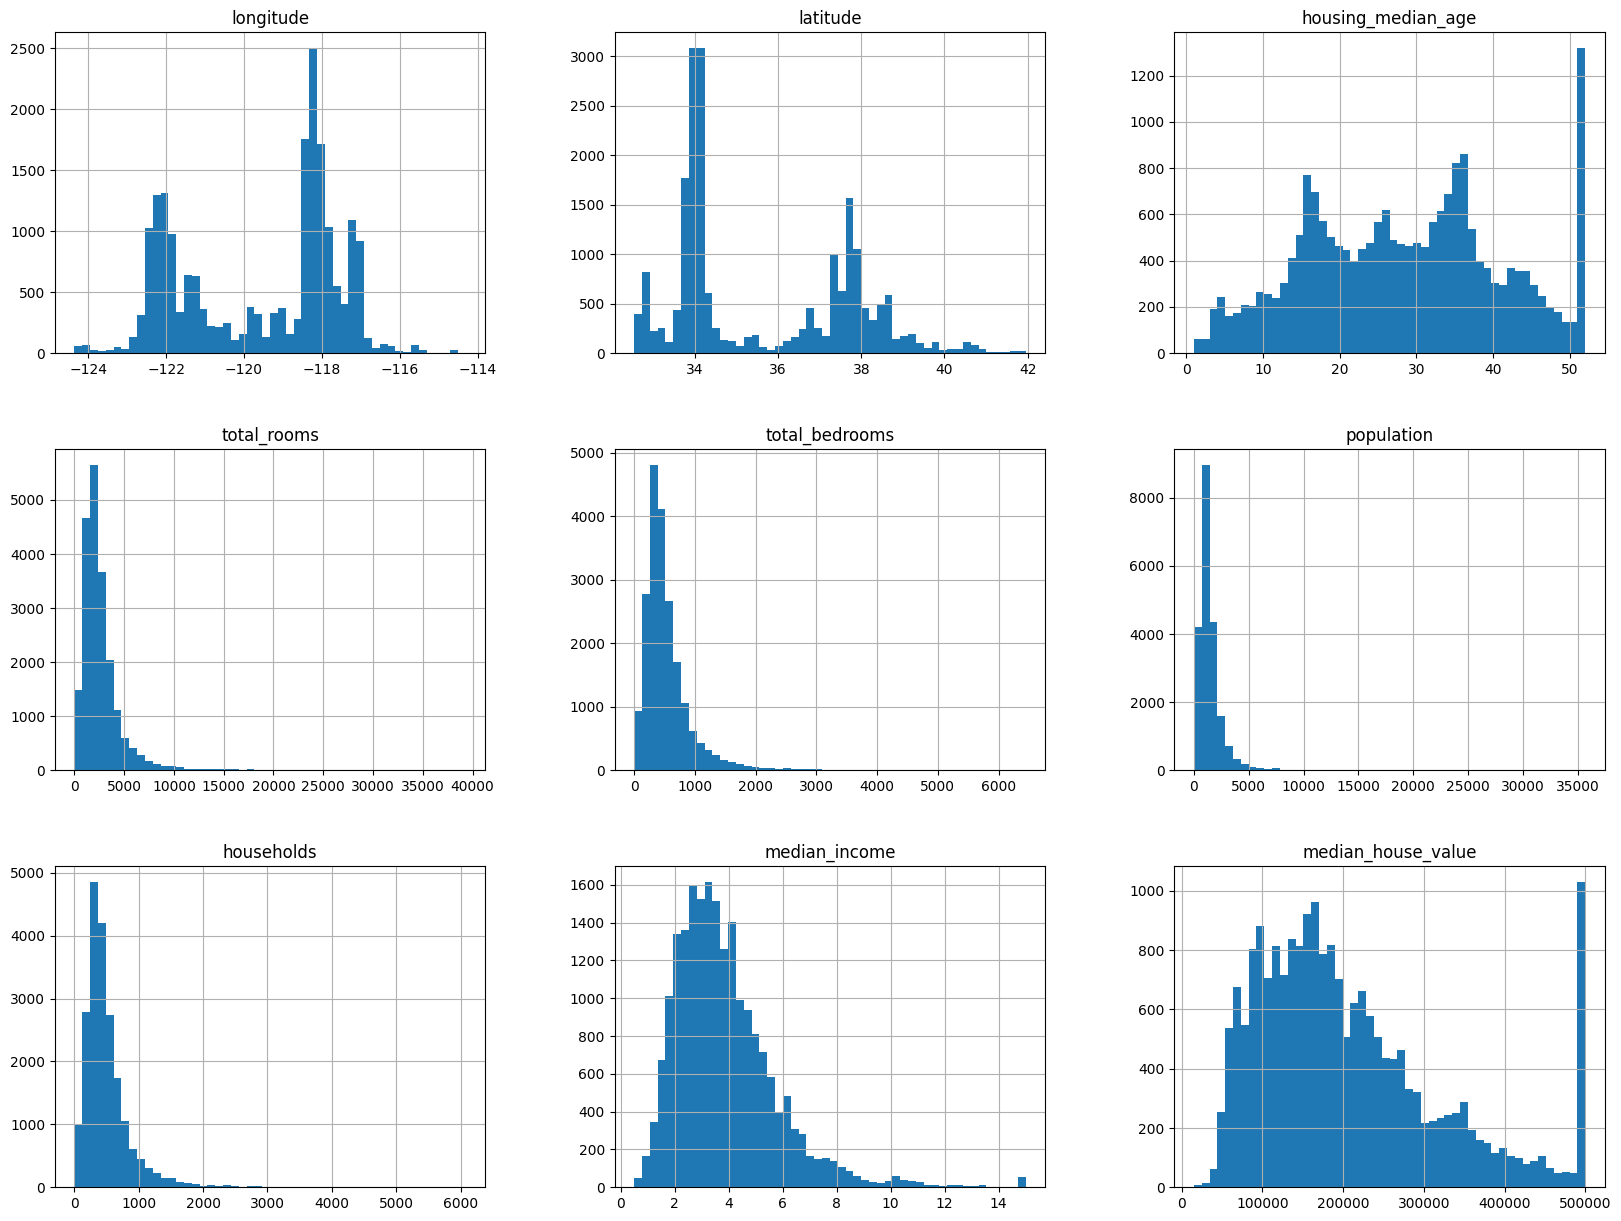

In [459]:
housing.hist(bins=50, figsize=(20,15))
plt.show()

# Spliting Trainging and Testing Set

### 一般train_test_split

如果使用行索引作為唯一識別碼，你需要保證新數據都放到現有數據的尾部，且沒有行被刪除。如果做不到，則可以用最穩定的特徵來創建唯一識別碼。例如，一個區的維度和經度在幾百萬年之內是不變的，所以可以將兩者結合成一個 ID：

In [8]:
housing["id"] = housing["longitude"] * 1000 + housing["latitude"]* 1000

Scikit-Learn 提供了一些函數，可以用多種方式將數據集分割成多個子集。最簡單的函數是train_test_split。它有一個random_state參數，可以設定前面講過的隨機生成器種子；第二，你可以將種子傳遞給多個行數相同的數據集，可以在相同的索引上分割數據集（這個功能非常有用，比如你的標籤值是放在另一個DataFrame裡的）
我們可以使用sklearn.model_selection中的train_test_split函數。雖然說是train-test split，但實際上是train-validation split 。


In [9]:
train_set, test_set = train_test_split(housing, test_size=0.2, random_state=42)

print('train_set\'s shape:')
print(train_set.shape)

print('test_set\'s shape:')
print(test_set.shape)

train_set's shape:
(16512, 11)
test_set's shape:
(4128, 11)


### 分層採樣StratifiedShuffleSplit

train_test_split是純隨機的取樣方法。當你的數據集很大時（尤其是和屬性數相比），這通常可行；但如果數據集不大，就會有採樣偏差的風險。當一個調查公司想要對 1000 個人進行調查，它們不是在電話亭裡隨機選 1000 個人出來。調查公司要保證這 1000 個人對人群整體有代表性。例如，美國人口的 51.3% 是女性，48.7% 是男性。所以在美國，嚴謹的調查需要保證樣本也是這個比例：513 名女性，487 名男性。這稱作分層採樣（stratified sampling）：將人群分成均勻的子分組，稱為分層，從每個分層去取合適數量的實例，以保證測試集對總人數有代表性。如果調查公司採用純隨機採樣，會有 12% 的概率導致採樣偏差：女性人數少於 49%，或多於 54%。不管發生那種情況，調查結果都會嚴重偏差。


假設專家告訴你，收入中位數是預測房價中位數非常重要的屬性。你可能想要保證測試集可以代表整體數據集中的多種收入分類。因為收入中位數是一個連續的數值屬性，你首先需要創建一個收入類別屬性。


<AxesSubplot: >

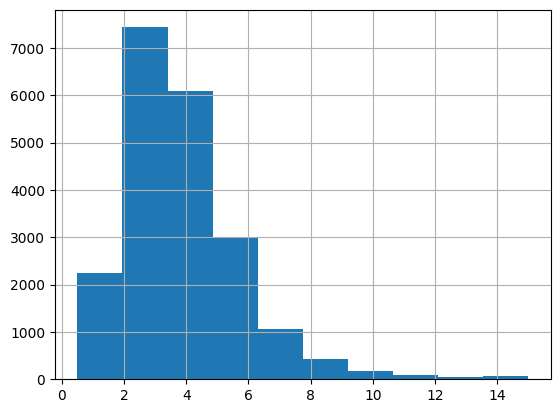

In [10]:
housing["median_income"].hist()

大多數的收入中位數的值聚集在 2-5（萬美元），但是一些收入中位數會超過 6。每個分層都要有足夠的觀察值，這點很重要。否則，對分層重要性的評估就會有偏差。這意味著，你不能有過多的分層，且每個分層都要足夠大。後面的代碼通過將收入中位數除以 1.5（以限制類別數量或層數），創建了一個收入類別屬性，用ceil對值舍入（以產生離散的分類），然後將所有大於 5 的分類歸入到分類 5：

In [11]:
housing["income_cat"] = np.ceil(housing["median_income"] / 1.5)
housing["income_cat"].where(housing["income_cat"] < 5, 5.0, inplace=True)

現在，就可以根據收入分類，進行分層採樣。你可以使用 Scikit-Learn 的StratifiedShuffleSplit

In [12]:
split = StratifiedShuffleSplit(n_splits=1, test_size=0.2, random_state=42)

for train_index, test_index in split.split(housing, housing["income_cat"]):
    strat_train_set = housing.loc[train_index]
    strat_test_set = housing.loc[test_index]

檢查結果是否符合預期。你可以比較原始資料與測試集中收入分類的比例：

In [13]:
strat_test_set["income_cat"].value_counts() / len(strat_test_set)

3.0    0.350533
2.0    0.318798
4.0    0.176357
5.0    0.114341
1.0    0.039971
Name: income_cat, dtype: float64

In [14]:
housing["income_cat"].value_counts() / len(housing)

3.0    0.350581
2.0    0.318847
4.0    0.176308
5.0    0.114438
1.0    0.039826
Name: income_cat, dtype: float64

可以建立表格比較，一目了然

In [15]:
def income_cat_proportions(data):
    return data["income_cat"].value_counts() / len(data)

compare_props = pd.DataFrame({
    "Overall": income_cat_proportions(housing),
    "Stratified": income_cat_proportions(strat_test_set)
    }).sort_index()
compare_props["Strat. %error"] = 100 * compare_props["Stratified"] / compare_props["Overall"] - 100
compare_props

Overall  Stratified  Strat. %error
1.0  0.039826    0.039971       0.364964
2.0  0.318847    0.318798      -0.015195
3.0  0.350581    0.350533      -0.013820
4.0  0.176308    0.176357       0.027480
5.0  0.114438    0.114341      -0.084674

現在，你需要刪除income_cat，使數據回到初始狀態：

In [16]:
for set in (strat_train_set, strat_test_set):
    set.drop(["income_cat"], axis=1, inplace=True)

In [17]:
strat_train_set.head()

longitude  latitude  housing_median_age  total_rooms  total_bedrooms  \
12655    -121.46     38.52                29.0       3873.0           797.0   
15502    -117.23     33.09                 7.0       5320.0           855.0   
2908     -119.04     35.37                44.0       1618.0           310.0   
14053    -117.13     32.75                24.0       1877.0           519.0   
20496    -118.70     34.28                27.0       3536.0           646.0   

       population  households  median_income  median_house_value  \
12655      2237.0       706.0         2.1736             72100.0   
15502      2015.0       768.0         6.3373            279600.0   
2908        667.0       300.0         2.8750             82700.0   
14053       898.0       483.0         2.2264            112500.0   
20496      1837.0       580.0         4.4964            238300.0   

      ocean_proximity       id  
12655          INLAND -82940.0  
15502      NEAR OCEAN -84140.0  
2908           INLAND -83670.0  
14053      NEAR OCEAN -84380.0  
20496       <1H OCEAN -84420.0

# EDA

目前為止，你只是快速查看了數據，對要處理的數據有了整體了解。現在的目標是更深的探索數據。

**首先，保證你將測試集放在了一旁，只是研究訓練集。** 另外，如果訓練集非常大，你可能需要再採樣一個探索集，保證操作方便快速。在我們的案例中，數據集很小，所以可以在全集上直接工作。創建一個副本，以免損傷訓練集：

In [18]:
housing = strat_train_set.copy()

### Correlation

來看下每個數值特徵和目標變數median_house_value的關聯度：

In [471]:
corr_matrix = housing.corr()
corr_matrix["median_house_value"].sort_values(ascending=False)

median_house_value    1.000000
median_income         0.687151
total_rooms           0.135140
housing_median_age    0.114146
households            0.064590
total_bedrooms        0.047781
population           -0.026882
longitude            -0.047466
latitude             -0.142673
id                   -0.490580
Name: median_house_value, dtype: float64

另一種檢測屬性間相關係數的方法是使用 Pandas 的scatter_matrix函數，它能畫出每個數值屬性對每個其它數值屬性的圖。因為現在共有 11 個數值屬性，你可以得到11 ** 2 = 121張圖，在一頁上畫不下，所以只關注幾個和房價中位數最有可能相關的屬性：

array([[<AxesSubplot: xlabel='median_house_value', ylabel='median_house_value'>,
        <AxesSubplot: xlabel='median_income', ylabel='median_house_value'>,
        <AxesSubplot: xlabel='total_rooms', ylabel='median_house_value'>,
        <AxesSubplot: xlabel='housing_median_age', ylabel='median_house_value'>],
       [<AxesSubplot: xlabel='median_house_value', ylabel='median_income'>,
        <AxesSubplot: xlabel='median_income', ylabel='median_income'>,
        <AxesSubplot: xlabel='total_rooms', ylabel='median_income'>,
        <AxesSubplot: xlabel='housing_median_age', ylabel='median_income'>],
       [<AxesSubplot: xlabel='median_house_value', ylabel='total_rooms'>,
        <AxesSubplot: xlabel='median_income', ylabel='total_rooms'>,
        <AxesSubplot: xlabel='total_rooms', ylabel='total_rooms'>,
        <AxesSubplot: xlabel='housing_median_age', ylabel='total_rooms'>],
       [<AxesSubplot: xlabel='median_house_value', ylabel='housing_median_age'>,
        <AxesSubplot: xlabel

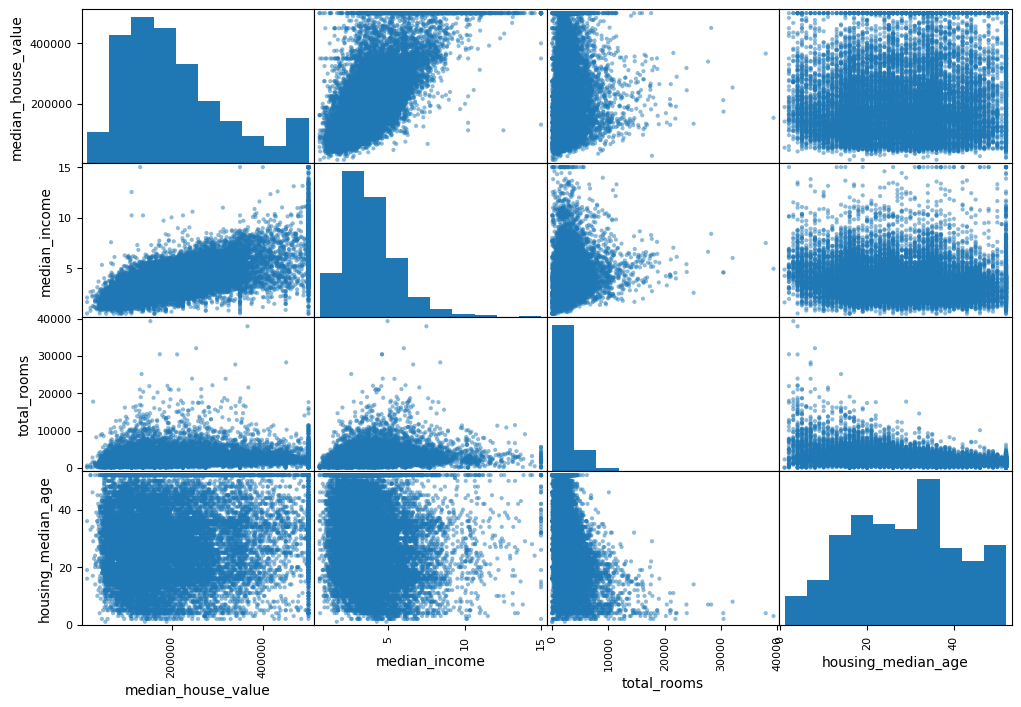

In [19]:
attributes = ["median_house_value", "median_income", "total_rooms",
              "housing_median_age"]
scatter_matrix(housing[attributes], figsize=(12, 8))

可以看到一些特徵是skew的

最有希望用來預測房價中位數的屬性是收入中位數，因此將這張圖放大

<AxesSubplot: xlabel='median_income', ylabel='median_house_value'>

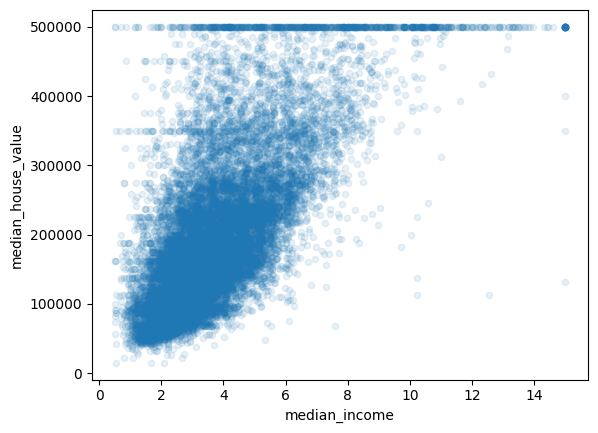

In [473]:
housing.plot(kind="scatter", x="median_income",y="median_house_value",
             alpha=0.1)

這張圖說明了幾點。首先，相關性非常高；可以清晰地看到向上的趨勢，並且數據點不是非常分散。第二，清晰地呈現一條位於 500000 美元的水平線，一條位於 450000 美元的直線，一條位於 350000 美元的直線，一條在 280000 美元的線，和一些更靠下的線。原因是由於此資料集當時給予你的時候，房屋價值中位數被設了上限，這可能是個嚴重的問題，因為它是目標特徵（標籤）。機器學習算法可能學習到價格不會超出這個界限。需要與下游團隊核實，這是否會成為問題。如果他們需要明確的預測值，即使超過 500000 美元，則有兩個選項：

1. 對於設了上限的標籤，重新收集合適的標籤；

2. 將這些街區從訓練集移除（也從測試集移除，因為若房價超出 500000 美元，你的模型評估就會差）。

### 地理數據可視化

因為存在地理信息（緯度和經度），創建一個所有街區的散點圖來數據可視化是一個不錯的主意

個圈的半徑表示街區的人口（s），顏色代表價格（c）。我們用預先定義的名為jet的顏色圖（cmap），它的範圍是從藍色（低價）到紅色（高價）：

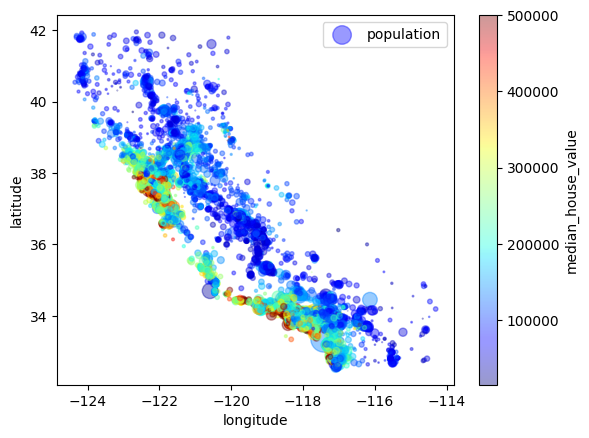

In [474]:
housing.plot(kind="scatter", x="longitude", y="latitude", alpha=0.4,
    s=housing["population"]/100, label="population",
    c="median_house_value", cmap=plt.get_cmap("jet"), colorbar=True,
)
plt.legend()

可以非常清楚地看到高密度區域，灣區、洛杉磯和圣迭戈，以及中央谷，特別是從薩克拉門托和弗雷斯諾。
這張圖說明房價和位置（比如，靠海）和人口密度聯繫密切。

再來看看實際在地圖上的分布

In [475]:
lats = list(housing['latitude'].values)
longs = list(housing['longitude'].values)
locations = list(zip(lats, longs))

# Creating a mapa using folium
map1 = folium.Map(location=[34, -115], zoom_start=6.0)

# Plugin: FastMarkerCluster
FastMarkerCluster(data=locations).add_to(map1)

map1

再來看看Heat Map

In [476]:
# Grouping geolocation data for plotting a heatmap
heat_data = housing.groupby(by = ['latitude', 'longitude'], as_index=False).count().iloc[:, :2]

# Creating a mapa using folium
map2 = folium.Map(
    location=[34, -115], 
    zoom_start=6.0, 
    tiles='cartodbdark_matter'
)

# Plugin: HeatMap
HeatMap(
    name='Mapa de Calor',
    data=heat_data,
    radius=8,
    max_zoom=13,
    blur = 13
).add_to(map2)

map2

用下載加州地圖的方式畫圖

In [477]:
# Where to save the figures
PROJECT_ROOT_DIR = "."
CHAPTER_ID = "end_to_end_project"
IMAGES_PATH = os.path.join(PROJECT_ROOT_DIR, "images", CHAPTER_ID)
os.makedirs(IMAGES_PATH, exist_ok=True)

def save_fig(fig_id, tight_layout=True, fig_extension="png", resolution=300):
    path = os.path.join(IMAGES_PATH, fig_id + "." + fig_extension)
    print("Saving figure", fig_id)
    if tight_layout:
        plt.tight_layout()
    plt.savefig(path, format=fig_extension, dpi=resolution)

In [478]:
# Download the California image
images_path = os.path.join(PROJECT_ROOT_DIR, "images", "end_to_end_project")
os.makedirs(images_path, exist_ok=True)
DOWNLOAD_ROOT = "https://raw.githubusercontent.com/ageron/handson-ml/master/"
filename = "california.png"
print("Downloading", filename)
url = DOWNLOAD_ROOT + "images/end_to_end_project/" + filename
urllib.request.urlretrieve(url, os.path.join(images_path, filename))

('.\\images\\end_to_end_project\\california.png',
 <http.client.HTTPMessage at 0x22353211650>)

C:\Users\PC\AppData\Local\Temp\ipykernel_16620\3558411363.py:16: UserWarning: FixedFormatter should only be used together with FixedLocator
  cbar.ax.set_yticklabels(["$%dk"%(round(v/1000)) for v in tick_values], fontsize=14)


Saving figure california_housing_prices_plot


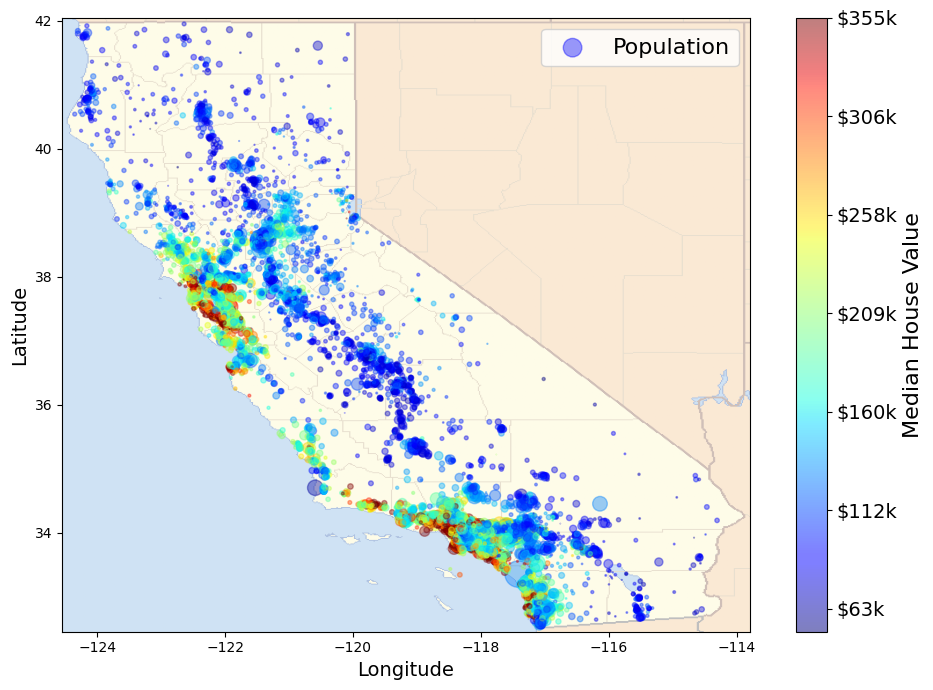

In [479]:
import matplotlib.image as mpimg
california_img=mpimg.imread(PROJECT_ROOT_DIR + '/images/end_to_end_project/california.png')
ax = housing.plot(kind="scatter", x="longitude", y="latitude", figsize=(10,7),
                       s=housing['population']/100, label="Population",
                       c="median_house_value", cmap=plt.get_cmap("jet"),
                       colorbar=False, alpha=0.4,
                      )
plt.imshow(california_img, extent=[-124.55, -113.80, 32.45, 42.05], alpha=0.5,
           cmap=plt.get_cmap("jet"))
plt.ylabel("Latitude", fontsize=14)
plt.xlabel("Longitude", fontsize=14)

prices = housing["median_house_value"]
tick_values = np.linspace(prices.min(), prices.max(), 11)
cbar = plt.colorbar()
cbar.ax.set_yticklabels(["$%dk"%(round(v/1000)) for v in tick_values], fontsize=14)
cbar.set_label('Median House Value', fontsize=16)

plt.legend(fontsize=16)
save_fig("california_housing_prices_plot")
plt.show()

### Summary of EDA 

1. 收入與房價高度相關，但是因為數據收集時有些狀況，房屋價值中位數被設了上限，這可能是個嚴重的問題，因為它是目標特徵（標籤），所以需要在給算法提供數據之前，將這些街區從訓練集與測試集移除。
   
2. 一些特徵具有長尾分佈，因此你可能要將其進行轉換（例如，計算其log對數）。

# Feature Generation

給算法準備數據之前，需要做的最後一件事是嘗試多種特徵組合。

1. 如果不知道某個街區有多少戶，該街區的總房間數就沒什麼用。真正需要的是每戶有幾個房間。

2. 總臥室數也不重要，可能需要將其與房間數進行比較。

3. 每戶的人口數也是一個有趣的特徵。

In [20]:
housing["rooms_per_household"] = housing["total_rooms"]/housing["households"]
housing["bedrooms_per_room"] = housing["total_bedrooms"]/housing["total_rooms"]
housing["population_per_household"]=housing["population"]/housing["households"]

現在，再來看相關矩陣：

In [21]:
corr_matrix = housing.corr()
corr_matrix["median_house_value"].sort_values(ascending=False)

median_house_value          1.000000
median_income               0.687151
rooms_per_household         0.146255
total_rooms                 0.135140
housing_median_age          0.114146
households                  0.064590
total_bedrooms              0.047781
population_per_household   -0.021991
population                 -0.026882
longitude                  -0.047466
latitude                   -0.142673
bedrooms_per_room          -0.259952
id                         -0.490580
Name: median_house_value, dtype: float64

* 與總房間數或臥室數相比，新的bedrooms_per_room屬性與房價中位數的關聯更強。顯然，臥室數/總房間數的比例越低，房價就越高。

* 每戶的房間數也比街區的總房間數的更有信息，很明顯，房屋越大，房價就越高。

這一步的數據探索不必非常完備，此處的目的是有一個正確的開始，快速發現規律，以得到一個合理的初始模型。但是這是一個交互過程：一旦你得到了一個初始模型，並運行起來，你就可以分析它的輸出，進而發現更多的規律，然後再回到數據探索這步。

# Data Preprocessing(without pipeline)

現在來為機器學習算法準備數據。不要手工來做，你需要寫一些函數，理由如下：

* 函數可以讓你在任何數據集上（比如，你下一次獲取的是一個新的數據集）方便地進行重複數據轉換。

* 你能慢慢建立一個轉換函數庫，可以在未來的項目中復用。

* 在將數據傳給算法之前，你可以在實時系統中使用這些函數。

* 這可以讓你方便地嘗試多種數據轉換，查看哪些轉換方法結合起來效果最好。

但是，還是先回到干淨的訓練集（通過再次復制strat_train_set），將預測變數和目標變數分開，因為我們不想對預測量和目標值應用相同的轉換（注意drop()創建了一份數據的備份，而不影響原本的strat_train_set）：

In [22]:
housing = strat_train_set.drop("median_house_value", axis=1)
housing_labels = strat_train_set["median_house_value"].copy()

housing.head()

longitude  latitude  housing_median_age  total_rooms  total_bedrooms  \
12655    -121.46     38.52                29.0       3873.0           797.0   
15502    -117.23     33.09                 7.0       5320.0           855.0   
2908     -119.04     35.37                44.0       1618.0           310.0   
14053    -117.13     32.75                24.0       1877.0           519.0   
20496    -118.70     34.28                27.0       3536.0           646.0   

       population  households  median_income ocean_proximity       id  
12655      2237.0       706.0         2.1736          INLAND -82940.0  
15502      2015.0       768.0         6.3373      NEAR OCEAN -84140.0  
2908        667.0       300.0         2.8750          INLAND -83670.0  
14053       898.0       483.0         2.2264      NEAR OCEAN -84380.0  
20496      1837.0       580.0         4.4964       <1H OCEAN -84420.0

In [23]:
housing_labels

12655     72100.0
15502    279600.0
2908      82700.0
14053    112500.0
20496    238300.0
           ...   
15174    268500.0
12661     90400.0
19263    140400.0
19140    258100.0
19773     62700.0
Name: median_house_value, Length: 16512, dtype: float64

### Data Cleaning

大多機器學習算法不能處理缺失的特徵，因此先創建一些函數來處理特徵缺失的問題。前面，你應該注意到了屬性total_bedrooms有一些缺失值。有三個解決選項：

1. 去掉對應的observations

2. 去掉整個屬性

3. 進行賦值（0、平均值、中位數等等）

隨機取幾個不完整的row來看看

In [484]:
sample_incomplete_rows = housing[housing.isnull().any(axis=1)].head()
sample_incomplete_rows

longitude  latitude  housing_median_age  total_rooms  total_bedrooms  \
1606     -122.08     37.88                26.0       2947.0             NaN   
10915    -117.87     33.73                45.0       2264.0             NaN   
19150    -122.70     38.35                14.0       2313.0             NaN   
4186     -118.23     34.13                48.0       1308.0             NaN   
16885    -122.40     37.58                26.0       3281.0             NaN   

       population  households  median_income ocean_proximity       id  
1606        825.0       626.0         2.9330        NEAR BAY -84200.0  
10915      1970.0       499.0         3.4193       <1H OCEAN -84140.0  
19150       954.0       397.0         3.7813       <1H OCEAN -84350.0  
4186        835.0       294.0         4.2891       <1H OCEAN -84100.0  
16885      1145.0       480.0         6.3580      NEAR OCEAN -84820.0

In [485]:
#housing.dropna(subset=["total_bedrooms"])    # 選項 1
#housing.drop("total_bedrooms", axis=1)       # 選項 2
#median = housing["total_bedrooms"].median()
#housing["total_bedrooms"].fillna(median)     # 選項 3

如果選擇選項 3，你需要計算訓練集的中位數，用中位數填充訓練集的缺失值，不要忘記保存該中位數。後面用測試集評估系統時，需要替換測試集中的缺失值，也可以用來實時替換新數據中的缺失值。

Scikit-Learn 提供了一個方便的類來處理缺失值：Imputer。下面是其使用方法：首先，需要創建一個Imputer實例，指定用某特徵的中位數來替換該特徵所有的缺失值：

In [486]:
imputer = SimpleImputer(strategy='median')
#因為只有數值屬性才能算出中位數，我們需要創建一份不包括字串(文本)特徵ocean_proximity的數據副本：
housing_num = housing.drop("ocean_proximity", axis=1)
#用fit()方法將imputer實例擬合到訓練數據
imputer.fit(housing_num)

SimpleImputer(strategy='median')

imputer計算出了每個特徵的中位數，並自動將結果保存在了statistics_中。雖然此時只有total_bedrooms存在缺失值，但我們不能確定在以後的新的數據中會不會有其他特徵也存在缺失值，所以安全的做法是將imputer應用到每個特徵：

In [487]:
#各特徵的中位數:
imputer.statistics_

array([-1.18510e+02,  3.42600e+01,  2.90000e+01,  2.11900e+03,
        4.33000e+02,  1.16400e+03,  4.08000e+02,  3.54155e+00,
       -8.41800e+04])

現在，就可以使用這個“訓練過的”imputer來對訓練集進行轉換，將缺失值替換為中位數：

In [488]:
X = imputer.transform(housing_num)
housing_NoNA = pd.DataFrame(X, columns=housing_num.columns,index=housing.index)#將其放回到 PandasDataFrame中
housing_NoNA.loc[sample_incomplete_rows.index.values]#看看剛剛隨機取出的那幾個有NA的row是否完整了

longitude  latitude  housing_median_age  total_rooms  total_bedrooms  \
1606     -122.08     37.88                26.0       2947.0           433.0   
10915    -117.87     33.73                45.0       2264.0           433.0   
19150    -122.70     38.35                14.0       2313.0           433.0   
4186     -118.23     34.13                48.0       1308.0           433.0   
16885    -122.40     37.58                26.0       3281.0           433.0   

       population  households  median_income       id  
1606        825.0       626.0         2.9330 -84200.0  
10915      1970.0       499.0         3.4193 -84140.0  
19150       954.0       397.0         3.7813 -84350.0  
4186        835.0       294.0         4.2891 -84100.0  
16885      1145.0       480.0         6.3580 -84820.0

### Encoding

前面丟棄了類別屬性ocean_proximity，因為它是一個文本(字串)屬性，不能計算出中位數。大多數機器學習算法更喜歡和數字打交道，所以讓我們把這些文本標籤轉換為數字。

In [489]:
housing_cat = housing[['ocean_proximity']]
housing_cat.head(10)

ocean_proximity
12655          INLAND
15502      NEAR OCEAN
2908           INLAND
14053      NEAR OCEAN
20496       <1H OCEAN
1481         NEAR BAY
18125       <1H OCEAN
5830        <1H OCEAN
17989       <1H OCEAN
4861        <1H OCEAN

Scikit-Learn 為這個任務提供了一個轉換器OneHotEncoder()：

In [490]:
cat_encoder = OneHotEncoder(sparse_output=False)#默認情況下，sparse_out=True返回一個稀疏矩陣，我們可以通過]sparse_out=False方法將其轉換為密集矩陣：
housing_cat_1hot = cat_encoder.fit_transform(housing_cat)
housing_cat_1hot

array([[0., 1., 0., 0., 0.],
       [0., 0., 0., 0., 1.],
       [0., 1., 0., 0., 0.],
       ...,
       [1., 0., 0., 0., 0.],
       [1., 0., 0., 0., 0.],
       [0., 1., 0., 0., 0.]])

看看有哪些類別

In [491]:
cat_encoder.categories_

[array(['<1H OCEAN', 'INLAND', 'ISLAND', 'NEAR BAY', 'NEAR OCEAN'],
       dtype=object)]

看看有那些features經過轉換

In [492]:
column_1hot = pd.DataFrame(housing_cat_1hot, columns=cat_encoder.get_feature_names_out())
column_1hot.head()

ocean_proximity_<1H OCEAN  ocean_proximity_INLAND  ocean_proximity_ISLAND  \
0                        0.0                     1.0                     0.0   
1                        0.0                     0.0                     0.0   
2                        0.0                     1.0                     0.0   
3                        0.0                     0.0                     0.0   
4                        1.0                     0.0                     0.0   

   ocean_proximity_NEAR BAY  ocean_proximity_NEAR OCEAN  
0                       0.0                         0.0  
1                       0.0                         1.0  
2                       0.0                         0.0  
3                       0.0                         1.0  
4                       0.0                         0.0

將features取出，當要套用於測試集時可以將轉換過後的特徵名稱用get_feature_names_out直接套用

In [493]:
df_test_unknown = pd.DataFrame({"ocean_proximity": ["<1H OCEAN", "ISLAND"]})#建立一個簡單的測試集
df_test_unknown

ocean_proximity
0       <1H OCEAN
1          ISLAND

In [494]:
pd.DataFrame(cat_encoder.transform(df_test_unknown),
                         columns=cat_encoder.get_feature_names_out(),
                         index=df_test_unknown.index)

ocean_proximity_<1H OCEAN  ocean_proximity_INLAND  ocean_proximity_ISLAND  \
0                        1.0                     0.0                     0.0   
1                        0.0                     0.0                     1.0   

   ocean_proximity_NEAR BAY  ocean_proximity_NEAR OCEAN  
0                       0.0                         0.0  
1                       0.0                         0.0

### Feature Scaling and Transformation

警告：與所有的estimators一樣，fit()或是fit_transform()只能向訓練集擬合，而不是向完整的數據集（包括測試集）。一旦你的estimator訓練完，你才能用transform()轉換測試集、訓練集和新數據。

#### Deal with Skewed Data

* Log Transformation

Saving figure long_tail_plot


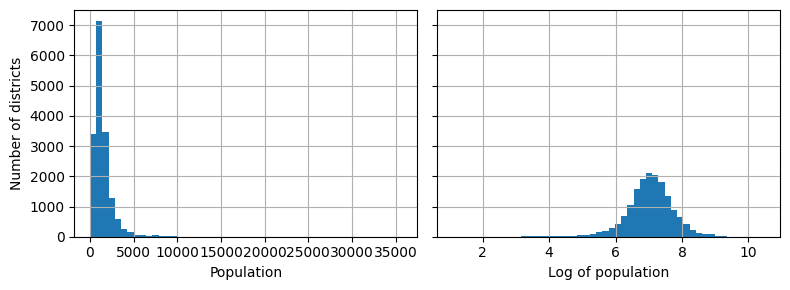

In [495]:
fig, axs = plt.subplots(1, 2, figsize=(8, 3), sharey=True)
housing["population"].hist(ax=axs[0], bins=50)
housing["population"] = housing["population"].apply(np.log)
housing["population"].hist(ax=axs[1], bins=50)
axs[0].set_xlabel("Population")
axs[1].set_xlabel("Log of population")
axs[0].set_ylabel("Number of districts")
save_fig("long_tail_plot")
plt.show()

也可以使用FunctionTransformer創建一個log transformer

In [496]:
log_transformer = FunctionTransformer(np.log, inverse_func=np.exp)
log_pop = log_transformer.transform(housing[["population"]])
log_pop.rename(columns={'population':'log_population'})

log_population
12655        2.042893
15502        2.029250
2908         1.872231
14053        1.916948
20496        2.017019
...               ...
15174        2.029965
12661        2.136518
19263        1.812684
19140        1.959633
19773        1.862179

[16512 rows x 1 columns]

* bucketizing

處理重尾特徵的另一種方法是對特徵進行分桶。 這意味著將其分佈分成大小大致相等的桶，並將每個特徵值替換為其所屬桶的索引。 例如，您可以將每個值替換為其百分位數。 使用大小相等的桶進行分桶會產生幾乎均勻分佈的特徵，因此無需進一步縮放，或者您可以僅除以桶數以將值強製到 0-1 範圍內。

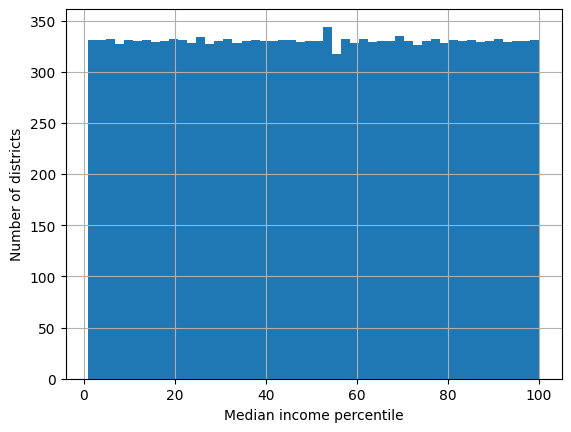

In [497]:
percentiles = [np.percentile(housing["median_income"], p)
               for p in range(1, 100)]
flattened_median_income = pd.cut(housing["median_income"],
                bins=[-np.inf] + percentiles + [np.inf],
                labels=range(1, 100 + 1))
# Note: incomes below the 1st percentile are labeled 1, and incomes above the 
# 99th percentile are labeled 100. This is why the distribution below ranges 
# from 1 to 100 (not 0 to 100).

flattened_median_income.hist(bins=50)
plt.xlabel("Median income percentile")
plt.ylabel("Number of districts")
plt.show()

#### Deal with multiple peaks data(多峰Data)

當一個特徵具有多模態分佈（即，具有兩個或更多清晰的峰，稱為modes）時，例如 housing_median_age 特徵，將數值變數分桶(分箱)可能會有所幫助，但這次將桶視為類別，而不是數值。 這意味著必須對桶索引進行編碼，例如使用一種熱編碼（因此您通常不想使用太多桶）。 這種方法將使回歸模型更容易地學習到針對該特徵值的不同範圍的不同規則。 例如，大約 35 年前建造的房屋可能具有一種不合時宜的奇特風格，因此它們的價格比單憑其年齡所表明的要便宜。

* Radial Basis Function(RBF)

array([[<AxesSubplot: title={'center': 'housing_median_age'}>]],
      dtype=object)

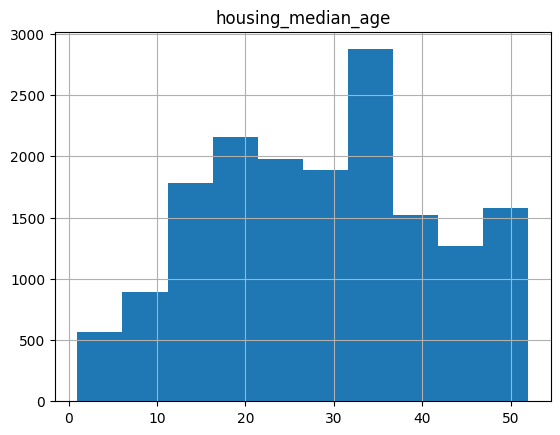

In [498]:
housing[["housing_median_age"]].hist()

另一種轉換多分佈的方法是為每個模式（至少是主要模式）添加一個特徵，以範例來說，表示住房年齡中位數與該特定模式之間的相似性。 相似性度量通常使用徑向基函數 (RBF) 計算——該函數僅取決於輸入值和固定點之間的距離。 最常用的 RBF 是Gaussian RBF，其輸出值隨著輸入值遠離固定點而呈指數衰減。 例如，住房年齡 x 和 35(高峰) 之間的Gaussian RBF 相似性由方程 exp(-gamma(x-35)^2 給出。超參數 gamma 決定了當 x 遠離 35 時相似性度量衰減的速度。
使用 Scikit-Learn 的 rbf_kernel() 函數，您可以創建一個新的高斯 RBF 特徵來測量各觀測值與 35 歲之間的相似性。


In [499]:
age_simil_35 = rbf_kernel(housing[["housing_median_age"]], [[35]], gamma=0.1)
age_simil_35

array([[2.73237224e-02],
       [8.93948745e-35],
       [3.03539138e-04],
       ...,
       [4.57533877e-08],
       [7.04065961e-20],
       [1.66155727e-03]])

或者創建一個rbf轉換器，要加入原本函式的參數用kw_args

In [500]:
rbf_transformer = FunctionTransformer(rbf_kernel,
                                      kw_args=dict(Y=[[35.]], gamma=0.1))
age_simil_35 = rbf_transformer.transform(housing[["housing_median_age"]])
age_simil_35

array([[2.73237224e-02],
       [8.93948745e-35],
       [3.03539138e-04],
       ...,
       [4.57533877e-08],
       [7.04065961e-20],
       [1.66155727e-03]])

#### Scaling

* Min-Max Scaling

In [501]:
min_max_scaler = MinMaxScaler(feature_range=(-1, 1))
housing_num_min_max_scaled = min_max_scaler.fit_transform(housing_NoNA)
housing_num_min_max_scaled

array([[-0.42430279,  0.27098831,  0.09803922, ..., -0.73711725,
        -0.76914801, -0.22368421],
       [ 0.41832669, -0.88310308, -0.76470588, ..., -0.71396565,
        -0.19485248, -0.53947368],
       [ 0.05776892, -0.39851222,  0.68627451, ..., -0.88872293,
        -0.67240452, -0.41578947],
       ...,
       [-0.6752988 ,  0.25398512,  0.84313725, ..., -0.93651979,
        -0.63037751, -0.57631579],
       [-0.67131474,  0.22635494, -0.49019608, ..., -0.81366692,
        -0.49014496, -0.60526316],
       [-0.55976096,  0.57917109,  0.01960784, ..., -0.92718447,
        -0.63697052, -0.02105263]])

* standardization

In [502]:
std_scaler = StandardScaler()
housing_num_std_scaled = std_scaler.fit_transform(housing_NoNA)
housing_num_std_scaled

array([[-0.94135046,  1.34743822,  0.02756357, ...,  0.55628602,
        -0.8936472 ,  1.22182938],
       [ 1.17178212, -1.19243966, -1.72201763, ...,  0.72131799,
         1.292168  , -0.24978014],
       [ 0.26758118, -0.1259716 ,  1.22045984, ..., -0.52440722,
        -0.52543365,  0.32660026],
       ...,
       [-1.5707942 ,  1.31001828,  1.53856552, ..., -0.86511838,
        -0.36547546, -0.42146792],
       [-1.56080303,  1.2492109 , -1.1653327 , ...,  0.01061579,
         0.16826095, -0.55636546],
       [-1.28105026,  2.02567448, -0.13148926, ..., -0.79857323,
        -0.390569  ,  2.16611216]])

編寫一個跟StandardScaler一樣的transformer

In [503]:
class StandardScalerClone(BaseEstimator, TransformerMixin):
    def __init__(self, with_mean=True):  # no *args or **kwargs!
        self.with_mean = with_mean

    def fit(self, X, y=None):  # y is required even though we don't use it
        X = check_array(X)  # checks that X is an array with finite float values
        self.mean_ = X.mean(axis=0)
        self.scale_ = X.std(axis=0)
        self.n_features_in_ = X.shape[1]  # every estimator stores this in fit()
        return self  # always return self!

    def transform(self, X):
        check_is_fitted(self)  # looks for learned attributes (with trailing _)
        X = check_array(X)
        assert self.n_features_in_ == X.shape[1]
        if self.with_mean:
            X = X - self.mean_
        return X / self.scale_

In [504]:
MyStandardTransformer = StandardScalerClone(with_mean=True)
housing_num_std_scaled = MyStandardTransformer.fit_transform(housing_NoNA)
housing_num_std_scaled

array([[-0.94135046,  1.34743822,  0.02756357, ...,  0.55628602,
        -0.8936472 ,  1.22182938],
       [ 1.17178212, -1.19243966, -1.72201763, ...,  0.72131799,
         1.292168  , -0.24978014],
       [ 0.26758118, -0.1259716 ,  1.22045984, ..., -0.52440722,
        -0.52543365,  0.32660026],
       ...,
       [-1.5707942 ,  1.31001828,  1.53856552, ..., -0.86511838,
        -0.36547546, -0.42146792],
       [-1.56080303,  1.2492109 , -1.1653327 , ...,  0.01061579,
         0.16826095, -0.55636546],
       [-1.28105026,  2.02567448, -0.13148926, ..., -0.79857323,
        -0.390569  ,  2.16611216]])

# End to End PipeLine of PreProcessing 

* Missing values in numerical features will be imputed by replacing them with the median. In categorical features, missing values will be replaced by the most frequent category.

* The categorical feature will be one-hot encoded.

* A few ratio features will be computed and added: bedrooms_ratio. room_per_house, and people_per_house. 

* A few cluster similarity features will also be added. These will likely be more useful than latitude and longitude variables.

* Feature with a long tail will be log transformation. Most algorithms prefer features with roughly uniform or Gaussian distributions.

* All numerical features will be standardized, as most ML algorithms prefer when features have roughly the same scale.

In [505]:
housing.head()

longitude  latitude  housing_median_age  total_rooms  total_bedrooms  \
12655    -121.46     38.52                29.0       3873.0           797.0   
15502    -117.23     33.09                 7.0       5320.0           855.0   
2908     -119.04     35.37                44.0       1618.0           310.0   
14053    -117.13     32.75                24.0       1877.0           519.0   
20496    -118.70     34.28                27.0       3536.0           646.0   

       population  households  median_income ocean_proximity       id  
12655    7.712891       706.0         2.1736          INLAND -82940.0  
15502    7.608374       768.0         6.3373      NEAR OCEAN -84140.0  
2908     6.502790       300.0         2.8750          INLAND -83670.0  
14053    6.800170       483.0         2.2264      NEAR OCEAN -84380.0  
20496    7.515889       580.0         4.4964       <1H OCEAN -84420.0

In [24]:
housing = housing.drop(['id'], axis=1)

In [25]:
num_attribs = ["longitude", "latitude", "housing_median_age", "total_rooms",
               "total_bedrooms", "population", "households", "median_income"]
cat_attribs = ["ocean_proximity"]

### Custom Transformer that will use later

* cluster_simil

在 fit() 方法中使用 KMeans 聚類來識別訓練數據中的主要聚類，然後在 transform() 方法中使用 rbf_kernel() 來衡量每個樣本與每個聚類中心的相似程度。
創建一個 ClusterSimilarity 轉換器，將簇數設置為 10。然後它使用訓練集中每個地區的緯度和經度調用 fit_transform()，按每個地區的房價中值 (Y) 加權。 transformer 使用 k-means 來定位集群，然後測量每個地區與所有 10 個集群中心之間的高斯 RBF 相似度。 結果是一個矩陣，每個區一行，每個集群一欄。

In [26]:
class ClusterSimilarity(BaseEstimator, TransformerMixin):
    def __init__(self, n_clusters = None, gamma = None, random_state = None):
        self.n_clusters = n_clusters
        self.gamma = gamma
        self.random_state = random_state

    def fit(self, X, y=None, sample_weight = None):
        self.kmeans_ = KMeans(self.n_clusters, random_state=self.random_state)
        self.kmeans_.fit(X, sample_weight=sample_weight)
        return self #always return self!
    
    def transform(self, X):
        return rbf_kernel(X, self.kmeans_.cluster_centers_, gamma=self.gamma)
    
    def get_feature_names_out(self, names=None):
        return [f"Cluster {i} similarity" for i in range(self.n_clusters)]
    

cluster_simil = ClusterSimilarity(n_clusters=10, gamma=1., random_state=42)

### Pipeline for creating Ratio Columns

In [27]:
def column_ratio(X):
    return X[:, [0]] / X[:, [1]]

def ratio_name(function_transformer, feature_names_in):
    return ["ratio"]  # feature names out

ratio_pipeline = Pipeline([
    ("impute", SimpleImputer(strategy="median")),
    ("ratiocol", FunctionTransformer(column_ratio, feature_names_out=ratio_name)),
    ("scale", StandardScaler()),
])

set_config(display='diagram')
ratio_pipeline

Pipeline(steps=[('impute', SimpleImputer(strategy='median')),
                ('ratiocol',
                 FunctionTransformer(feature_names_out=<function ratio_name at 0x0000019B6BCF5F80>,
                                     func=<function column_ratio at 0x0000019B6BCF74C0>)),
                ('scale', StandardScaler())])

### Pipeline for Log Transformation

In [28]:
log_pipeline = Pipeline([
    ("imputer", SimpleImputer(strategy="median")),
    ("log", FunctionTransformer(np.log, feature_names_out="one-to-one")),
    ("scale", StandardScaler()),
])

set_config(display='diagram')
log_pipeline

Pipeline(steps=[('imputer', SimpleImputer(strategy='median')),
                ('log',
                 FunctionTransformer(feature_names_out='one-to-one',
                                     func=<ufunc 'log'>)),
                ('scale', StandardScaler())])

### Pipeline for Numeric Variables

In [29]:
num_pipeline = Pipeline([
    ("impute", SimpleImputer(strategy="median")),
    ("standardize", StandardScaler()),
])

set_config(display='diagram')
num_pipeline

Pipeline(steps=[('impute', SimpleImputer(strategy='median')),
                ('standardize', StandardScaler())])

### Pipeline for Category Variables

In [30]:
cat_pipeline = Pipeline([
    ("impute", SimpleImputer(strategy="most_frequent")),
    ("encoding", OneHotEncoder(handle_unknown="ignore")),
])

set_config(display='diagram')
cat_pipeline

Pipeline(steps=[('impute', SimpleImputer(strategy='most_frequent')),
                ('encoding', OneHotEncoder(handle_unknown='ignore'))])

### Pipeline for Remain Variables

In [31]:
remain_num_pipeline = Pipeline([
    ("impute", SimpleImputer(strategy="median")),
    ("scale", StandardScaler()),
])

set_config(display='diagram')
remain_num_pipeline

Pipeline(steps=[('impute', SimpleImputer(strategy='median')),
                ('scale', StandardScaler())])

### Preprocessing

In [32]:
preprocessing = ColumnTransformer([
        ("bedrooms", ratio_pipeline, ["total_bedrooms", "total_rooms"]),
        ("rooms_per_house", ratio_pipeline, ["total_rooms", "households"]),
        ("people_per_house", ratio_pipeline, ["population", "households"]),
        ("log", log_pipeline, ["total_bedrooms", "total_rooms", "population",
                               "households", "median_income"]),
        ("geo", cluster_simil, ["latitude", "longitude"]),
        ("cat", cat_pipeline, make_column_selector(dtype_include=object)),
    ],
    remainder=remain_num_pipeline)  # one column remaining: housing_median_age

preprocessing

ColumnTransformer(remainder=Pipeline(steps=[('impute',
                                             SimpleImputer(strategy='median')),
                                            ('scale', StandardScaler())]),
                  transformers=[('bedrooms',
                                 Pipeline(steps=[('impute',
                                                  SimpleImputer(strategy='median')),
                                                 ('ratiocol',
                                                  FunctionTransformer(feature_names_out=<function ratio_name at 0x0000019B6BCF5F80>,
                                                                      func=<function column_ratio at 0x0000019B6BCF74C0>)),
                                                 ('scal...
                                 ['total_bedrooms', 'total_rooms', 'population',
                                  'households', 'median_income']),
                                ('geo',
                                 ClusterSimilarity(gamma=1.0, n_clusters=10,
                                                   random_state=42),
                                 ['latitude', 'longitude']),
                                ('cat',
                                 Pipeline(steps=[('impute',
                                                  SimpleImputer(strategy='most_frequent')),
                                                 ('encoding',
                                                  OneHotEncoder(handle_unknown='ignore'))]),
                                 <sklearn.compose._column_transformer.make_column_selector object at 0x0000019B6BE4E010>)])

In [33]:
housing_prepared = preprocessing.fit_transform(housing)
housing_prepared.shape

(16512, 24)

In [34]:
preprocessing.get_feature_names_out()

array(['bedrooms__ratio', 'rooms_per_house__ratio',
       'people_per_house__ratio', 'log__total_bedrooms',
       'log__total_rooms', 'log__population', 'log__households',
       'log__median_income', 'geo__Cluster 0 similarity',
       'geo__Cluster 1 similarity', 'geo__Cluster 2 similarity',
       'geo__Cluster 3 similarity', 'geo__Cluster 4 similarity',
       'geo__Cluster 5 similarity', 'geo__Cluster 6 similarity',
       'geo__Cluster 7 similarity', 'geo__Cluster 8 similarity',
       'geo__Cluster 9 similarity', 'cat__ocean_proximity_<1H OCEAN',
       'cat__ocean_proximity_INLAND', 'cat__ocean_proximity_ISLAND',
       'cat__ocean_proximity_NEAR BAY', 'cat__ocean_proximity_NEAR OCEAN',
       'remainder__housing_median_age'], dtype=object)

In [35]:
df_housing_final = pd.DataFrame(
    housing_prepared, 
    columns=preprocessing.get_feature_names_out(),
    index=housing.index
)
df_housing_final.head()

bedrooms__ratio  rooms_per_house__ratio  people_per_house__ratio  \
12655        -0.121122                0.017395                 0.006223   
15502        -0.810867                0.569256                -0.040811   
2908         -0.338273               -0.018024                -0.075371   
14053         0.961205               -0.595140                -0.106803   
20496        -0.474513                0.251241                 0.006109   

       log__total_bedrooms  log__total_rooms  log__population  \
12655             0.873403          0.852032         0.938249   
15502             0.970407          1.277433         0.796538   
2908             -0.430559         -0.317644        -0.702499   
14053             0.281063         -0.118663        -0.299288   
20496             0.583337          0.730040         0.671139   

       log__households  log__median_income  geo__Cluster 0 similarity  \
12655         0.797843           -0.998832               3.391002e-16   
15502         0.913214            1.277742               4.197435e-01   
2908         -0.375177           -0.403837               1.810043e-02   
14053         0.277558           -0.947769               1.937594e-01   
20496         0.528397            0.547635               2.991692e-01   

       geo__Cluster 1 similarity  ...  geo__Cluster 6 similarity  \
12655               4.706064e-01  ...               1.070616e-13   
15502               1.850749e-16  ...               1.233912e-01   
2908                6.391756e-05  ...               1.041204e-01   
14053               3.147969e-18  ...               4.545497e-02   
20496               2.354275e-08  ...               8.143973e-01   

       geo__Cluster 7 similarity  geo__Cluster 8 similarity  \
12655               8.217042e-01               1.493399e-07   
15502               1.272655e-22               6.521017e-05   
2908                2.191546e-08               5.466398e-01   
14053               9.457060e-25               9.793789e-06   
20496               5.612523e-13               2.281453e-01   

       geo__Cluster 9 similarity  cat__ocean_proximity_<1H OCEAN  \
12655               1.579689e-01                             0.0   
15502               7.678546e-18                             0.0   
2908                6.801739e-06                             0.0   
14053               1.564997e-19                             0.0   
20496               4.312614e-09                             1.0   

       cat__ocean_proximity_INLAND  cat__ocean_proximity_ISLAND  \
12655                          1.0                          0.0   
15502                          0.0                          0.0   
2908                           1.0                          0.0   
14053                          0.0                          0.0   
20496                          0.0                          0.0   

       cat__ocean_proximity_NEAR BAY  cat__ocean_proximity_NEAR OCEAN  \
12655                            0.0                              0.0   
15502                            0.0                              1.0   
2908                             0.0                              0.0   
14053                            0.0                              1.0   
20496                            0.0                              0.0   

       remainder__housing_median_age  
12655                       0.027564  
15502                      -1.722018  
2908                        1.220460  
14053                      -0.370069  
20496                      -0.131489  

[5 rows x 24 columns]

# Select and Train a Model

## Train and Evalute on the Training Set

**開始建立模型(feature selection的步驟寫在比較後面，這裡其實就要做了)**

好消息是基於前面的工作，接下來要做的比你想的要簡單許多。先來訓練一個最簡單的線性回歸模型：

(目前為止我們並沒有對housing_labels，也就是median_house_value做任何轉換)

<AxesSubplot: >

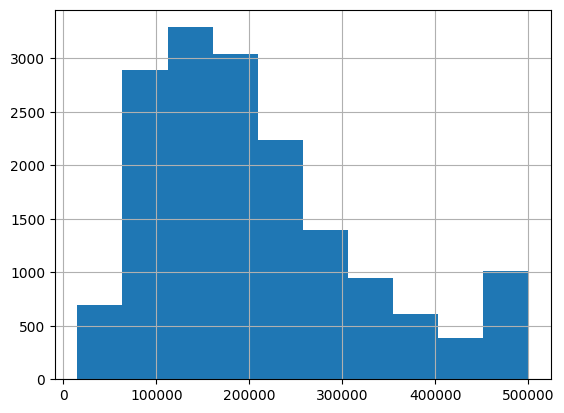

In [518]:
housing_labels.hist()

### Try Linear Regression

In [519]:
from sklearn.linear_model import LinearRegression

建立一個可以將前面preprocessin transformer與線性回歸模型演算法連接起來的Pipeline

In [520]:
lin_reg = make_pipeline(preprocessing, 
                        LinearRegression()
                        )


Fit on Training Data

In [521]:
lin_reg.fit(housing, housing_labels)

Pipeline(steps=[('columntransformer',
                 ColumnTransformer(remainder=Pipeline(steps=[('impute',
                                                              SimpleImputer(strategy='median')),
                                                             ('scale',
                                                              StandardScaler())]),
                                   transformers=[('bedrooms',
                                                  Pipeline(steps=[('impute',
                                                                   SimpleImputer(strategy='median')),
                                                                  ('ratiocol',
                                                                   FunctionTransformer(feature_names_out=<function ratio_name at 0x00000223EC891D00>,
                                                                                       func=<function colum...
                                                 ('geo',
                                                  ClusterSimilarity(gamma=1.0,
                                                                    n_clusters=10,
                                                                    random_state=42),
                                                  ['latitude', 'longitude']),
                                                 ('cat',
                                                  Pipeline(steps=[('impute',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('encoding',
                                                                   OneHotEncoder(handle_unknown='ignore'))]),
                                                  <sklearn.compose._column_transformer.make_column_selector object at 0x00000223EAD31710>)])),
                ('linearregression', LinearRegression())])

Predict on Training Data

In [522]:
housing_predictions = lin_reg.predict(housing)
housing_predictions[:5].round(-2)  # -2 = rounded to the nearest hundred

array([ 79800., 290000., 171400., 177300., 280700.])

Compare against the actual values:

In [523]:
housing_labels.iloc[:5].values

array([ 72100., 279600.,  82700., 112500., 238300.])

In [524]:
from sklearn.metrics import mean_squared_error

lin_rmse = mean_squared_error(housing_labels, housing_predictions,
                              squared=False)#Set squared = False if using RMSE
lin_rmse

70019.107636451

Clearly not a great score: the median_housing_values of most districts range between $120000 and $265000, so a typical prediction error of $68628 is really not very satisfying. This is an example of underfitting the training data.

* Better Evaluation Using Cross Validation 

In [525]:
from sklearn.model_selection import cross_val_score

Scilit-Learn 的交叉驗證功能使用utility function（越大越好）而不是cost function越低越好），因此scoring實際上與 RMSE 相反。 這是一個負值，因此您需要加上負號以獲得 RMSE 分數。

In [526]:
regression_rmses = -cross_val_score(lin_reg, housing, housing_labels, scoring="neg_root_mean_squared_error", cv=10)
pd.Series(regression_rmses).describe()

count       10.000000
mean     72180.536075
std       8024.187769
min      65553.593020
25%      67748.953822
50%      70981.357795
75%      71983.467394
max      93893.621246
dtype: float64

請注意，交叉驗證不僅可以讓您獲得模型性能的估計值，還可以衡量該估計值的精確度（即標準差）。

模型表現還是很差

### Try Decision Tree

In [527]:
from sklearn.tree import DecisionTreeRegressor


建立一個可以將前面preprocessin transformer與回歸決策樹演算法連接起來的Pipeline

In [528]:
tree_reg = make_pipeline(preprocessing, DecisionTreeRegressor(random_state=42))

Fit on Training Data

In [529]:
tree_reg.fit(housing, housing_labels)

Pipeline(steps=[('columntransformer',
                 ColumnTransformer(remainder=Pipeline(steps=[('impute',
                                                              SimpleImputer(strategy='median')),
                                                             ('scale',
                                                              StandardScaler())]),
                                   transformers=[('bedrooms',
                                                  Pipeline(steps=[('impute',
                                                                   SimpleImputer(strategy='median')),
                                                                  ('ratiocol',
                                                                   FunctionTransformer(feature_names_out=<function ratio_name at 0x00000223EC891D00>,
                                                                                       func=<function colum...
                                                  ClusterSimilarity(gamma=1.0,
                                                                    n_clusters=10,
                                                                    random_state=42),
                                                  ['latitude', 'longitude']),
                                                 ('cat',
                                                  Pipeline(steps=[('impute',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('encoding',
                                                                   OneHotEncoder(handle_unknown='ignore'))]),
                                                  <sklearn.compose._column_transformer.make_column_selector object at 0x00000223EAD31710>)])),
                ('decisiontreeregressor',
                 DecisionTreeRegressor(random_state=42))])

Predict on Training Data

In [530]:
housing_predictions = tree_reg.predict(housing)

Compare against the actual values:

In [531]:
tree_rmse = mean_squared_error(housing_labels, housing_predictions,
                              squared=False)
tree_rmse

0.0

Clearly it is overfitting

* Better Evaluation Using Cross Validation 

Scilit-Learn 的交叉驗證功能使用utility function（越大越好）而不是cost function越低越好），因此scoring實際上與 RMSE 相反。 這是一個負值，因此您需要加上負號以獲得 RMSE 分數。

In [532]:
tree_rmses = -cross_val_score(tree_reg, housing, housing_labels,
                              scoring="neg_root_mean_squared_error", cv=10)
pd.Series(tree_rmses).describe()

count       10.000000
mean     66601.489802
std       1910.270257
min      64095.718636
25%      64917.994230
50%      66758.835031
75%      67792.664063
max      69358.750366
dtype: float64

決策樹模型的性能似乎比線性回歸模型略好，但由於嚴重的過度擬合，差異很小。 我們知道存在過度擬合問題，因為訓練誤差很低（實際上為零）而驗證誤差很高。

### Try Random Forest

In [533]:
from sklearn.ensemble import RandomForestRegressor

建立一個可以將前面preprocessin transformer與回歸隨機森林算法連接起來的Pipeline

In [534]:
forest_reg = make_pipeline(preprocessing,
                           RandomForestRegressor(random_state=42))

Fit on Training Data

In [535]:
forest_reg.fit(housing, housing_labels)

Pipeline(steps=[('columntransformer',
                 ColumnTransformer(remainder=Pipeline(steps=[('impute',
                                                              SimpleImputer(strategy='median')),
                                                             ('scale',
                                                              StandardScaler())]),
                                   transformers=[('bedrooms',
                                                  Pipeline(steps=[('impute',
                                                                   SimpleImputer(strategy='median')),
                                                                  ('ratiocol',
                                                                   FunctionTransformer(feature_names_out=<function ratio_name at 0x00000223EC891D00>,
                                                                                       func=<function colum...
                                                  ClusterSimilarity(gamma=1.0,
                                                                    n_clusters=10,
                                                                    random_state=42),
                                                  ['latitude', 'longitude']),
                                                 ('cat',
                                                  Pipeline(steps=[('impute',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('encoding',
                                                                   OneHotEncoder(handle_unknown='ignore'))]),
                                                  <sklearn.compose._column_transformer.make_column_selector object at 0x00000223EAD31710>)])),
                ('randomforestregressor',
                 RandomForestRegressor(random_state=42))])

Predict on Training Data

In [536]:
housing_predictions = forest_reg.predict(housing)

Compare against the actual values:

In [537]:
forest_rmse = mean_squared_error(housing_labels, housing_predictions,
                                 squared=False)
forest_rmse

17658.845960872808

* Better Evaluation Using Cross Validation 

Scilit-Learn 的交叉驗證功能使用utility function（越大越好）而不是cost function越低越好），因此scoring實際上與 RMSE 相反。 這是一個負值，因此您需要加上負號以獲得 RMSE 分數。

In [538]:
forest_rmses = -cross_val_score(forest_reg, housing, housing_labels,
                                scoring="neg_root_mean_squared_error", cv=10)

In [539]:
pd.Series(forest_rmses).describe()

count       10.000000
mean     47570.520811
std       2252.500107
min      43592.351224
25%      46084.988356
50%      47914.596689
75%      48848.489196
max      51157.305241
dtype: float64

訓練誤差遠低於驗證誤差，這通常意味著模型過度擬合了訓練集。 另一種可能的解釋可能是訓練數據和驗證數據之間存在不匹配，但這裡並非如此，因為它們都來自同一個數據集，我們將其打亂並拆分為兩部分。
在深入隨機森林調參數之前，你應該嘗試下機器學習算法的其它類型模型（不同核心的支持向量機，神經網絡，等等），不要在調節超參數上花費太多時間。目標是列出一個可能模型的列表（兩到五個）。

# Tuning

### Grid Search

In [540]:
from sklearn.model_selection import GridSearchCV


將預處理轉換器與隨機森林連接

In [41]:
cache_der = "."
full_pipeline = Pipeline([
    ("preprocessing", preprocessing),
    ("random_forest", RandomForestRegressor(random_state=42)),
], memory=cache_der)

查看整個管道中所有可以調整的參數

In [542]:
#  shows part of the output of get_params().keys()
print(str(full_pipeline.get_params().keys())[:1000] + "...")

dict_keys(['memory', 'steps', 'verbose', 'preprocessing', 'random_forest', 'preprocessing__n_jobs', 'preprocessing__remainder__memory', 'preprocessing__remainder__steps', 'preprocessing__remainder__verbose', 'preprocessing__remainder__impute', 'preprocessing__remainder__scale', 'preprocessing__remainder__impute__add_indicator', 'preprocessing__remainder__impute__copy', 'preprocessing__remainder__impute__fill_value', 'preprocessing__remainder__impute__keep_empty_features', 'preprocessing__remainder__impute__missing_values', 'preprocessing__remainder__impute__strategy', 'preprocessing__remainder__impute__verbose', 'preprocessing__remainder__scale__copy', 'preprocessing__remainder__scale__with_mean', 'preprocessing__remainder__scale__with_std', 'preprocessing__remainder', 'preprocessing__sparse_threshold', 'preprocessing__transformer_weights', 'preprocessing__transformers', 'preprocessing__verbose', 'preprocessing__verbose_feature_names_out', 'preprocessing__bedrooms', 'preprocessing__roo

設置想要調的參數組合

In [543]:
param_grid = [
    {'preprocessing__geo__n_clusters':[5,8,10],
     'random_forest__max_features':[4,6,8]},
     {'preprocessing__geo__n_clusters':[10,15],
     'random_forest__max_features':[6,8,10]},
]

這個param_grid中有兩個字典，所以GridSearch會先評估n_clusters和max_features的所有3x3=9組合，然後它會嘗試所有2x3=6的超參數值組合。 所以總的來說，GRIDSEARCH 將探索 9+6=15 個超參數值組合，並且它將對每個組合訓練 3 次，因為使用了 3 折交叉驗證。 這意味著總共會有 15x3=45 輪的訓練。

開始尋找嘗試參數

In [544]:
grid_search = GridSearchCV(full_pipeline, param_grid, cv=3,
                           scoring='neg_root_mean_squared_error')
grid_search.fit(housing, housing_labels)

GridSearchCV(cv=3,
             estimator=Pipeline(memory='.',
                                steps=[('preprocessing',
                                        ColumnTransformer(remainder=Pipeline(steps=[('impute',
                                                                                     SimpleImputer(strategy='median')),
                                                                                    ('scale',
                                                                                     StandardScaler())]),
                                                          transformers=[('bedrooms',
                                                                         Pipeline(steps=[('impute',
                                                                                          SimpleImputer(strategy='median')),
                                                                                         ('ratiocol',
                                                                                          FunctionTransformer(feature_names_out=<function ratio_name at 0x00...
                                                                         <sklearn.compose._column_transformer.make_column_selector object at 0x00000223EAD31710>)])),
                                       ('random_forest',
                                        RandomForestRegressor(random_state=42))]),
             param_grid=[{'preprocessing__geo__n_clusters': [5, 8, 10],
                          'random_forest__max_features': [4, 6, 8]},
                         {'preprocessing__geo__n_clusters': [10, 15],
                          'random_forest__max_features': [6, 8, 10]}],
             scoring='neg_root_mean_squared_error')

  **請注意，您可以引用管道中任何估計器的任何超參數，即使該估計器嵌套在多個管道和列轉換器的深處。 例如，當 Sickit-Learn 看到“preprocessing__geo__n_clusters”時，它會在雙下劃線處拆分此字符串，然後在管道中查找名為“preprocessing”的估計器並找到預處理 ColumnTransforemer。 接下來，它在 ColumnTransformer 中查找名為“geo”的轉換器，並找到我們在緯度和經度特徵上使用的 ClusterSimilarity 轉換器。 然後它找到這個轉換器的 n_clusters 超參數。 同樣，random_forest__max 特徵指的是名為“random_forest”的估計器的 max_features 超參數。**

**在 Scikit-Learn 管道中包裝預處理步驟允許您調整預處理超參數以及模型超參數。 這是一件好事，因為他們經常互動。 例如，增加 n_clusters 可能也需要增加 max_features。 如果擬合管道轉換器的計算量很大，您可以將管道的memory超參數設置為儲存模型的路徑：當您首次擬合管道時，Scikit-Learn 會將擬合的轉換器保存到該目錄。 如果您隨後使用相同的超參數再次擬合管道，Scikit-Learn 將只加載緩存的轉換器。**

查看最佳參數組合

In [545]:
grid_search.best_params_

{'preprocessing__geo__n_clusters': 15, 'random_forest__max_features': 6}

此時，因為n_clusters = 15是我們找的參數中的最大值，所以這時應該回去尋找值更大的參數，模型表現可能會更好

查看參數組合的表現

In [546]:
cv_res = pd.DataFrame(grid_search.cv_results_)
cv_res.sort_values(by="mean_test_score", ascending=False, inplace=True)

# extra code – these few lines of code just make the DataFrame look nicer
cv_res = cv_res[["param_preprocessing__geo__n_clusters",
                 "param_random_forest__max_features", "split0_test_score",
                 "split1_test_score", "split2_test_score", "mean_test_score"]]
score_cols = ["split0_cv", "split1_cv", "split2_cv", "mean_test_rmse"]
cv_res.columns = ["n_clusters", "max_features"] + score_cols

#一樣看分數加上負號
cv_res[score_cols] = -cv_res[score_cols].round().astype(np.int64)

cv_res.head()

n_clusters max_features  split0_cv  split1_cv  split2_cv  mean_test_rmse
12         15            6      44098      46008      46109           45405
13         15            8      44174      46108      46119           45467
14         15           10      44783      46767      46603           46051
7          10            6      45402      47045      47298           46581
9          10            6      45402      47045      47298           46581

將管道與 GridSearchCV 結合使用，不僅可以為您的模型找到最佳超參數，還可以為您的機器學習任務找到最佳轉換器
例如，你可以透過GridSearchCV找最佳impute缺失值的策略、最佳pca的component數、最佳的encoding方式等等。

詳細看https://towardsdatascience.com/are-you-using-pipeline-in-scikit-learn-ac4cd85cb27f

最後，將整個pipeline與最佳參數存起來

In [547]:
from sklearn.utils import estimator_html_repr 

grid_search.best_estimator_

# saving pipeline as html format
with open('pipeline_estimator.html', 'w', encoding="utf-8") as f:  
    f.write(estimator_html_repr(grid_search.best_estimator_))

### Randomized Search

當探索相對較少的組合時，就像前面的例子，Grid Search還可以。但是當超參數的搜索空間很大時，最好使用RandomizedSearchCV。使用方法和GridSearchCV很相似，但它不是嘗試所有可能的組合，而是通過選擇每個超參數的一個隨機值的特定數量的隨機組合。這個方法有兩個優點：

* 如果你讓隨機搜索迴圈運行，比如 1000 次，它會探索每個超參數的 1000 個不同的值（而不是像網格搜索那樣，只搜索每個超參數的幾個值）。

* 你可以方便地通過設定搜索次數，控制超參數搜索的計算量。

In [37]:
from sklearn.experimental import enable_halving_search_cv
from sklearn.model_selection import HalvingRandomSearchCV
from sklearn.model_selection import RandomizedSearchCV
from scipy.stats import randint

嘗試 30 (n_iter × cv) 個超參數的隨機組合：

In [58]:
param_distribs = {'preprocessing__geo__n_clusters':randint(low=3,high=50),
                  'random_forest__max_features':randint(low=2,high=20)}

rnd_search = RandomizedSearchCV(
    full_pipeline, param_distributions=param_distribs,n_iter=10, cv=3,
    scoring='neg_root_mean_squared_error', random_state=42)

rnd_search.fit(housing, housing_labels)

c:\Users\PC\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\pipeline.py:359: UserWarning: Persisting input arguments took 0.56s to run.
If this happens often in your code, it can cause performance problems 
(results will be correct in all cases). 
The reason for this is probably some large input arguments for a wrapped
 function (e.g. large strings).
THIS IS A JOBLIB ISSUE. If you can, kindly provide the joblib's team with an
 example so that they can fix the problem.
  X, fitted_transformer = fit_transform_one_cached(


RandomizedSearchCV(cv=3,
                   estimator=Pipeline(memory='.',
                                      steps=[('preprocessing',
                                              ColumnTransformer(remainder=Pipeline(steps=[('impute',
                                                                                           SimpleImputer(strategy='median')),
                                                                                          ('scale',
                                                                                           StandardScaler())]),
                                                                transformers=[('bedrooms',
                                                                               Pipeline(steps=[('impute',
                                                                                                SimpleImputer(strategy='median')),
                                                                                               ('ratiocol',
                                                                                                FunctionTransformer(feature_names_out=<function ratio_name...
                                             ('random_forest',
                                              RandomForestRegressor(random_state=42))]),
                   param_distributions={'preprocessing__geo__n_clusters': <scipy.stats._distn_infrastructure.rv_discrete_frozen object at 0x0000019B00730790>,
                                        'random_forest__max_features': <scipy.stats._distn_infrastructure.rv_discrete_frozen object at 0x0000019B7F7032D0>},
                   random_state=42, scoring='neg_root_mean_squared_error')

查看參數組合的表現

In [550]:
# extra code – displays the random search results
cv_res = pd.DataFrame(rnd_search.cv_results_)
cv_res.sort_values(by="mean_test_score", ascending=False, inplace=True)
cv_res = cv_res[["param_preprocessing__geo__n_clusters",
                 "param_random_forest__max_features", "split0_test_score",
                 "split1_test_score", "split2_test_score", "mean_test_score"]]
score_cols = ["split0_cv", "split1_cv", "split2_cv", "mean_test_rmse"]
cv_res.columns = ["n_clusters", "max_features"] + score_cols
cv_res[score_cols] = -cv_res[score_cols].round().astype(np.int64)
cv_res.head()

n_clusters max_features  split0_cv  split1_cv  split2_cv  mean_test_rmse
1         45            9      42279      44192      43575           43349
8         32            7      42569      44403      44157           43710
5         42            4      42437      44959      44186           43861
0         41           16      43237      44529      44502           44089
2         23            8      43482      45086      44886           44485

### Random Search時如何決定參數選擇採樣分佈

* scipy.stats.randint(a, b+1)：對於具有從 a 到 b 範圍內的離散值的超參數，並且該範圍內的所有值似乎都是同樣可能的。

* cipy.stats.uniform(a, b)：與randint非常相似，但用於連續超參數。

* scipy.stats.geom(1 / scale)：對於離散值，當你想在給定的範圍下粗略採樣時。 例如，scale=1000 時，大多數樣本都在這個範圍內，但所有樣本中約有 10% 將 <100，約 10% 將 >2300。

* scipy.stats.expon(scale)：這是 geom 的連續值版本。 只需將scale設置為最可能的值。

* scipy.stats.loguniform(a, b)：當你幾乎不知道最佳超參數值的範圍是多少時。 如果您設置 a=0.01 和 b=100，那麼您採樣 0.01 到 0.1 之間的值的可能性與採樣 10 到 100 之間的值的可能性一樣。

以下是 randint()、uniform()、geom() 和 expon() 的概率質量函數（對於離散變量）和概率密度函數（對於連續變量）的圖：

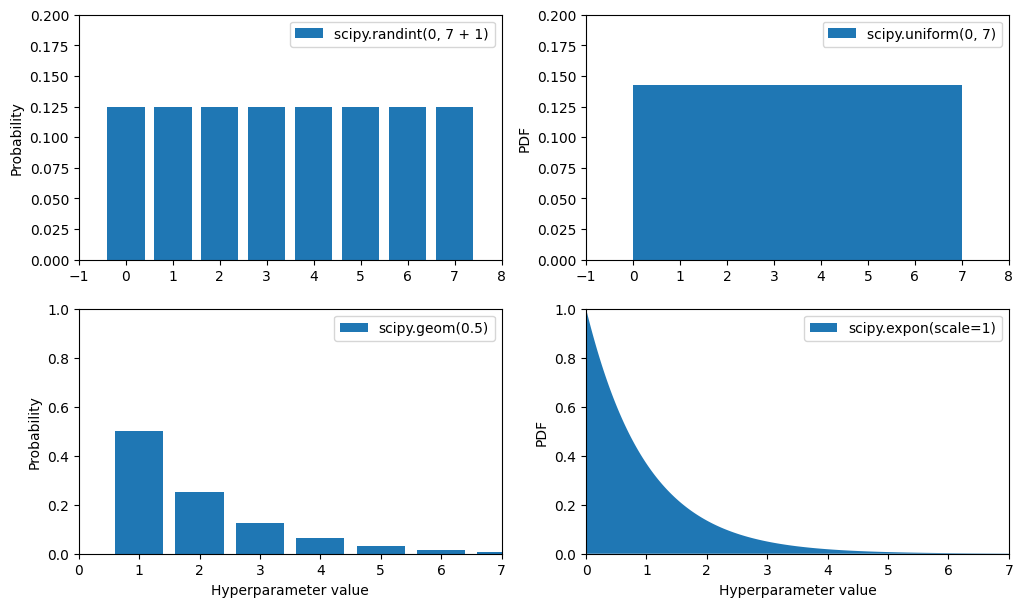

In [551]:
from scipy.stats import randint, uniform, geom, expon

xs1 = np.arange(0, 7 + 1)#生成一個介於0到 7（含）之間的值陣列。添加 +1 以包括範圍中的上限。
randint_distrib = randint(0, 7 + 1).pmf(xs1)#計算數組中每個離散數值的均勻分佈的概率密度函數 (PMF)，PMF 表示給定範圍內每個點的概率密度，指示從均勻分佈中觀察到特定值的可能性。

xs2 = np.linspace(0, 7, 500)#生成 0 到 7 之間的 500 個均勻分佈的值，包括 0 和 7。
uniform_distrib = uniform(0, 7).pdf(xs2)#計算數組中每個連續數值的均勻分佈的概率密度函數 (PDF)，PDF 表示給定範圍內每個點的概率密度，指示從均勻分佈中觀察到特定值的可能性。

#創建一個從 0 到 7 的值陣列，為成功概率為 0.5 的幾何分佈生成 PMF，PMF 表示給定範圍內每個點的概率品質，表示從幾何分佈中觀察到每個特定值的可能性。
xs3 = np.arange(0, 7 + 1)
geom_distrib = geom(0.5).pmf(xs3)

#碼創建從 0 到 7 的值範圍，為刻度參數為 1 的指數分佈生成 PDF。PDF 表示給定範圍內每個點的概率密度，指示從指數分佈中觀察到特定值的可能性。
xs4 = np.linspace(0, 7, 500)
expon_distrib = expon(scale=1).pdf(xs4)

plt.figure(figsize=(12, 7))

plt.subplot(2, 2, 1)
plt.bar(xs1, randint_distrib, label="scipy.randint(0, 7 + 1)")
plt.ylabel("Probability")
plt.legend()
plt.axis([-1, 8, 0, 0.2])

plt.subplot(2, 2, 2)
plt.fill_between(xs2, uniform_distrib, label="scipy.uniform(0, 7)")
plt.ylabel("PDF")
plt.legend()
plt.axis([-1, 8, 0, 0.2])

plt.subplot(2, 2, 3)
plt.bar(xs3, geom_distrib, label="scipy.geom(0.5)")
plt.xlabel("Hyperparameter value")
plt.ylabel("Probability")
plt.legend()
plt.axis([0, 7, 0, 1])

plt.subplot(2, 2, 4)
plt.fill_between(xs4, expon_distrib, label="scipy.expon(scale=1)")
plt.xlabel("Hyperparameter value")
plt.ylabel("PDF")
plt.legend()
plt.axis([0, 7, 0, 1])

plt.show()

上圖右邊的Y軸PDF跟左邊的Probability一樣，只是離散跟連續數值的差別，圖代表參數被取到的機率。真正在做的時候也可以把圖畫出，明確知道找的參數分布與機率。

下圖是 expon() 和 loguniform()（左欄）的 PDF，以及取log後（右欄）的 PDF。 右列顯示超參數尺度的分佈。 可以看到 expon() 傾向於具有大致所需比例的超參數，較長的尾巴朝向較小的比例。 但是 loguniform() 不支持任何尺度，它們都是同樣可能的：

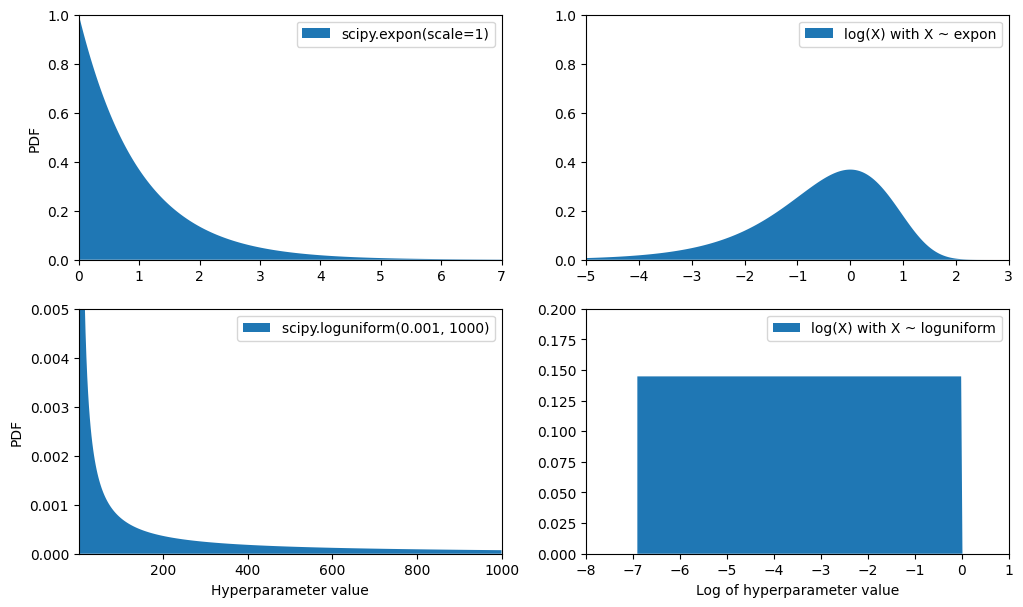

In [552]:
from scipy.stats import loguniform
#跟上面右下一樣
xs1 = np.linspace(0, 7, 500)
expon_distrib = expon(scale=1).pdf(xs1)
#創建了一個從 -5 到 3 的值範圍，通過從 log_xs2 中減去 np.exp(log_xs2) 然後應用指數函數來生成轉換后的分佈。
log_xs2 = np.linspace(-5, 3, 500)
log_expon_distrib = np.exp(log_xs2 - np.exp(log_xs2))
#生成從 0.001 到 1000 的值範圍，為具有指定邊界的對數均勻分佈生成 PDF。
xs3 = np.linspace(0.001, 1000, 500)#在0.01與1000之間生成 500 個均勻分佈的值。
loguniform_distrib = loguniform(0.001, 1000).pdf(xs3)
#生成的值範圍從自然對數0.001到自然對數1000。然後，它通過將下限和上限設置為相應的自然對數，為在此範圍內定義的均勻分佈創建一個 PDF。
log_xs4 = np.linspace(np.log(0.001), np.log(1000), 500)
log_loguniform_distrib = uniform(np.log(0.001), np.log(1000)).pdf(log_xs4)

plt.figure(figsize=(12, 7))

plt.subplot(2, 2, 1)
plt.fill_between(xs1, expon_distrib,
                 label="scipy.expon(scale=1)")
plt.ylabel("PDF")
plt.legend()
plt.axis([0, 7, 0, 1])

plt.subplot(2, 2, 2)
plt.fill_between(log_xs2, log_expon_distrib,
                 label="log(X) with X ~ expon")
plt.legend()
plt.axis([-5, 3, 0, 1])

plt.subplot(2, 2, 3)
plt.fill_between(xs3, loguniform_distrib,
                 label="scipy.loguniform(0.001, 1000)")
plt.xlabel("Hyperparameter value")
plt.ylabel("PDF")
plt.legend()
plt.axis([0.001, 1000, 0, 0.005])

plt.subplot(2, 2, 4)
plt.fill_between(log_xs4, log_loguniform_distrib,
                 label="log(X) with X ~ loguniform")
plt.xlabel("Log of hyperparameter value")
plt.legend()
plt.axis([-8, 1, 0, 0.2])
plt.show()

###  HalvingRandomSearchCV 和 HalvingGridSearchCV

Scikit-Learn 也有 HalvingRandomSearchCV 和 HalvingGridSearchCV。兩個基於successive halving的function，使用了非常非常常用的技巧稱為Multi-Fidelity Search。他們的目標是更有效地使用計算資源，以更快地訓練或探索更大的超參數空間。顧名思義兩個function最大的差異就是底層我們使用的search方法一個是Grid Search另一個則是Random Search。

In [553]:
from sklearn.experimental import enable_halving_search_cv  
from sklearn.model_selection import HalvingGridSearchCV
from sklearn.model_selection import HalvingRandomSearchCV

* HalvingGridSearchCV

(param_grid用上面grid search設的)

In [554]:
halving_search = HalvingGridSearchCV(full_pipeline, param_grid, scoring='neg_root_mean_squared_error', cv=3, random_state=42)

halving_search.fit(housing, housing_labels)

HalvingGridSearchCV(cv=3,
                    estimator=Pipeline(memory='.',
                                       steps=[('preprocessing',
                                               ColumnTransformer(remainder=Pipeline(steps=[('impute',
                                                                                            SimpleImputer(strategy='median')),
                                                                                           ('scale',
                                                                                            StandardScaler())]),
                                                                 transformers=[('bedrooms',
                                                                                Pipeline(steps=[('impute',
                                                                                                 SimpleImputer(strategy='median')),
                                                                                                ('ratiocol',
                                                                                                 FunctionTransformer(feature_names_out=<function ratio_nam...
                                                                                <sklearn.compose._column_transformer.make_column_selector object at 0x00000223EAD31710>)])),
                                              ('random_forest',
                                               RandomForestRegressor(random_state=42))]),
                    param_grid=[{'preprocessing__geo__n_clusters': [5, 8, 10],
                                 'random_forest__max_features': [4, 6, 8]},
                                {'preprocessing__geo__n_clusters': [10, 15],
                                 'random_forest__max_features': [6, 8, 10]}],
                    random_state=42, scoring='neg_root_mean_squared_error')

查看參數組合的表現

方法一

In [555]:
pd.DataFrame(halving_search.best_params_, index=[0])\
.assign(RMSE=-halving_search.best_score_)

preprocessing__geo__n_clusters  random_forest__max_features          RMSE
0                              15                            8  45428.283168

方法二

In [556]:
cv_res = pd.DataFrame(halving_search.cv_results_)
cv_res.sort_values(by="mean_test_score", ascending=False, inplace=True)
cv_res = cv_res[["param_preprocessing__geo__n_clusters",
                 "param_random_forest__max_features", "split0_test_score",
                 "split1_test_score", "split2_test_score", "mean_test_score"]]
score_cols = ["split0_cv", "split1_cv", "split2_cv", "mean_test_rmse"]
cv_res.columns = ["n_clusters", "max_features"] + score_cols
cv_res[score_cols] = -cv_res[score_cols].round().astype(np.int64)
cv_res.head()

n_clusters max_features  split0_cv  split1_cv  split2_cv  mean_test_rmse
21         15            8      44383      46102      45799           45428
20         15            6      44267      46180      45891           45446
19         15            8      47951      53025      49426           50134
18         15            6      47824      52820      49773           50139
17         15           10      48529      53259      49656           50481

* HalvingRandomSearchCV

(param_distribs用上面random search的)

In [56]:
#halving_search_random = HalvingRandomSearchCV(full_pipeline, param_distribs, scoring='neg_root_mean_squared_error', cv=3, random_state=42, error_score='raise')

#halving_search_random.fit(housing, housing_labels)

查看參數組合的表現

方法一

In [61]:
#pd.DataFrame(halving_search_random.best_params_, index=[0])\.assign(RMSE=-halving_search_random.best_score_)

方法二

In [160]:
#cv_res = pd.DataFrame(halving_search_random.cv_results_)
#cv_res.sort_values(by="mean_test_score", ascending=False, inplace=True)
#cv_res = cv_res[["param_preprocessing__geo__n_clusters","param_random_forest__max_features", "split0_test_score","split1_test_score", "split2_test_score", "mean_test_score"]]
#score_cols = ["split0_cv", "split1_cv", "split2_cv", "mean_test_rmse"]
#cv_res.columns = ["n_clusters", "max_features"] + score_cols
#cv_res[score_cols] = -cv_res[score_cols].round()
#cv_res.head()

n_clusters max_features  split0_cv  split1_cv  split2_cv  mean_test_rmse
4129         24           18    46402.0    48119.0    47593.0         47371.0
4128          9           12    47991.0    49473.0    49543.0         49003.0
4127         24           18    49730.0    53291.0    50998.0         51340.0
4126          9           12    52373.0    56223.0    51775.0         53457.0
4124         12           18    52241.0    56056.0    52505.0         53600.0

## Analyzing the Best Models and their Errors

通過分析最佳模型(這邊使用上面random search出來的模型)，常常可以獲得對問題更深的了解。比如，RandomForestRegressor可以指出每個特徵對於做出準確預測的相對重要性：

In [59]:
final_model = rnd_search.best_estimator_  # includes preprocessing
feature_importances = final_model["random_forest"].feature_importances_
feature_importances.round(2)

array([0.07, 0.05, 0.05, 0.01, 0.01, 0.01, 0.01, 0.19, 0.01, 0.01, 0.01,
       0.01, 0.01, 0.02, 0.  , 0.01, 0.03, 0.  , 0.01, 0.01, 0.02, 0.01,
       0.  , 0.02, 0.01, 0.  , 0.01, 0.01, 0.01, 0.  , 0.01, 0.01, 0.01,
       0.01, 0.01, 0.02, 0.01, 0.02, 0.01, 0.01, 0.01, 0.01, 0.01, 0.03,
       0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.  , 0.07,
       0.  , 0.  , 0.  , 0.01])

In [60]:
importance = sorted(zip(feature_importances,
           final_model["preprocessing"].get_feature_names_out()),
           reverse=True)

pd.DataFrame(importance, columns=['importance', 'variables']).head()

importance                    variables
0    0.186049           log__median_income
1    0.073717  cat__ocean_proximity_INLAND
2    0.071854              bedrooms__ratio
3    0.054415       rooms_per_house__ratio
4    0.052175      people_per_house__ratio

有了這個信息，就可以丟棄一些不那麼重要的特徵（比如，顯然只要一個ocean_proximity的類型（ISLAND）就夠了，所以可以丟棄掉其它的）。

還應該看一下系統犯的誤差，搞清為什麼會有些誤差，以及如何改正問題（添加更多的特徵，或相反，去掉沒有什麼信息的特徵，清洗異常值等等）

還需要確保您的模型不僅在平均水平上運行良好，而且在所有類別的地區中都運行良好，無論是農村還是城市、富人還是窮人、北方還是南方。 為每個類別創建驗證集的子集需要一些努力，但這很重要。 如果您的模型在整個地區類別上表現不佳，那麼在問題解決之前可能不應該部署它，或者至少不應該使用它對該類別進行預測。

### Feature Selection(SelectFromModel)

主要參數說明如下：

* estimator: 用來構建transformer的基本估計器。既可以是擬合的（如果prefit設置為True），也可以是不擬合的估計器。這個估計器擬合之後必須具有 feature_importances_或coef_屬性。隨機森林、xgboost、lasso或ridge回歸都可以，我們下面用的是rnd_search(前面的隨機森林)

* threshold：用於特徵選擇的閾值。保留重要性更高或相等的特徵，而其特徵則被丟棄。 threshold為特徵重要性的mean或者median，也可以使用縮放（例如，“ 1.25 *mean”）。如果為None，並且估計器的參數懲罰顯式或隱式設置為l1（例如Lasso），則使用的閾值為1e-5。否則，默認情況下使用mean。

* prefit：預設模型是否期望直接傳遞給構造函數，預設為False，之後再fit跟transform就好。

* norm_order：在估算器threshold的coef_特徵為維度2 的情況下，用於過濾以下係數矢量的範數的順序。

* max_features：要選擇的最大特徵數，若要僅基於max_features選擇，請設置threshold=-np.inf。

In [171]:
from sklearn.feature_selection import SelectFromModel

In [181]:
full_pipeline_with_feature_selection = Pipeline([
    ("preprocessing", preprocessing),
    ("selection", SelectFromModel(RandomForestRegressor(), threshold='median')),
    ("random_forest", RandomForestRegressor(random_state=42)),
], memory=cache_der)

使用random search找參數(param_distribs用前面random search那邊設過的)

In [182]:
rnd_search_with_feature_selection = RandomizedSearchCV(
    full_pipeline_with_feature_selection, param_distributions=param_distribs, n_iter=10, cv=3,
    scoring='neg_root_mean_squared_error', random_state=42)

rnd_search_with_feature_selection.fit(housing, housing_labels)

c:\Users\PC\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


RandomizedSearchCV(cv=3,
                   estimator=Pipeline(memory='.',
                                      steps=[('preprocessing',
                                              ColumnTransformer(remainder=Pipeline(steps=[('impute',
                                                                                           SimpleImputer(strategy='median')),
                                                                                          ('scale',
                                                                                           StandardScaler())]),
                                                                transformers=[('bedrooms',
                                                                               Pipeline(steps=[('impute',
                                                                                                SimpleImputer(strategy='median')),
                                                                                               ('ratiocol',
                                                                                                FunctionTransformer(feature_names_out=<function ratio_name...
                                             ('random_forest',
                                              RandomForestRegressor(random_state=42))]),
                   param_distributions={'preprocessing__geo__n_clusters': <scipy.stats._distn_infrastructure.rv_discrete_frozen object at 0x000002235AB3ECD0>,
                                        'random_forest__max_features': <scipy.stats._distn_infrastructure.rv_discrete_frozen object at 0x000002235BA76690>},
                   random_state=42, scoring='neg_root_mean_squared_error')

被選出的特徵名稱

In [253]:
best_estimator = rnd_search_with_feature_selection.best_estimator_

#經過最佳數據預處理及轉換的資料變數名稱
original_feature_names = best_estimator.named_steps['preprocessing'].get_feature_names_out()

#經由selection步驟選出的變數
selected_features = best_estimator.named_steps['selection'].get_support()
selected_feature_names = original_feature_names[selected_features]
selected_feature_names

array(['bedrooms__ratio', 'rooms_per_house__ratio',
       'people_per_house__ratio', 'log__total_bedrooms',
       'log__total_rooms', 'log__population', 'log__median_income',
       'geo__Cluster 1 similarity', 'geo__Cluster 4 similarity',
       'geo__Cluster 5 similarity', 'geo__Cluster 7 similarity',
       'geo__Cluster 9 similarity', 'geo__Cluster 10 similarity',
       'geo__Cluster 14 similarity', 'geo__Cluster 19 similarity',
       'geo__Cluster 21 similarity', 'geo__Cluster 23 similarity',
       'geo__Cluster 26 similarity', 'geo__Cluster 27 similarity',
       'geo__Cluster 28 similarity', 'geo__Cluster 30 similarity',
       'geo__Cluster 31 similarity', 'geo__Cluster 32 similarity',
       'geo__Cluster 36 similarity', 'geo__Cluster 39 similarity',
       'geo__Cluster 41 similarity', 'cat__ocean_proximity_INLAND',
       'remainder__housing_median_age'], dtype=object)

建模前最終資料(經過資料預處理及特徵選擇)

In [258]:
#經過最佳數據預處理及轉換的資料
best_data = best_estimator.named_steps['preprocessing'].transform(housing)

#最終被selection步驟選出的特徵並放回dataframe
pd.DataFrame(best_data[:, selected_features], columns=selected_feature_names)

bedrooms__ratio  rooms_per_house__ratio  people_per_house__ratio  \
0            -0.121122                0.017395                -0.336831   
1            -0.810867                0.569256                -0.364959   
2            -0.338273               -0.018024                -0.039785   
3             0.961205               -0.595140                -0.249682   
4            -0.474513                0.251241                -0.280643   
...                ...                     ...                      ...   
16507        -0.443846                0.466353                -0.428520   
16508        -0.516065                0.050362                -0.473641   
16509         0.322869               -0.509240                 0.345514   
16510        -0.457023                0.328149                -0.247303   
16511        -0.121697                0.014072                 0.264218   

       log__total_bedrooms  log__total_rooms  log__population  \
0                 0.873403          0.852032         0.856447   
1                 0.970407          1.277433         0.739945   
2                -0.430559         -0.317644        -0.600829   
3                 0.281063         -0.118663        -0.218998   
4                 0.583337          0.730040         0.635511   
...                    ...               ...              ...   
16507             1.473719          1.579483         0.746053   
16508             1.672897          1.807457         1.655905   
16509            -1.293050         -1.427119        -1.109302   
16510             0.434515          0.577261         0.145491   
16511            -0.891636         -0.860586        -0.686662   

       log__median_income  geo__Cluster 1 similarity  \
0               -0.998832               8.785245e-14   
1                1.277742               1.400090e-01   
2               -0.403837               1.019869e-01   
3               -0.947769               4.989766e-02   
4                0.547635               7.219341e-01   
...                   ...                        ...   
16507            0.811447               8.935189e-02   
16508           -0.449539               1.247881e-13   
16509           -0.189525               8.413769e-18   
16510            0.400730               3.026571e-17   
16511           -0.221750               2.354981e-22   

       geo__Cluster 4 similarity  geo__Cluster 5 similarity  ...  \
0                   3.953830e-03               2.580938e-01  ...   
1                   9.935802e-10               7.016241e-22  ...   
2                   6.363341e-02               3.908478e-08  ...   
3                   4.088076e-11               8.964276e-24  ...   
4                   4.164409e-04               5.450413e-12  ...   
...                          ...                        ...  ...   
16507               2.689813e-10               7.455442e-23  ...   
16508               4.655650e-03               2.428855e-01  ...   
16509               1.674086e-05               5.928454e-01  ...   
16510               2.803839e-05               6.970498e-01  ...   
16511               2.468791e-07               8.650277e-03  ...   

       geo__Cluster 27 similarity  geo__Cluster 28 similarity  \
0                    1.040008e-01                1.239362e-12   
1                    9.072355e-20                5.894770e-02   
2                    3.829357e-07                1.919837e-01   
3                    7.754292e-22                1.886592e-02   
4                    1.610173e-11                9.499848e-01   
...                           ...                         ...   
16507                1.735960e-20                3.350028e-02   
16508                1.148281e-01                1.711109e-12   
16509                5.702216e-04                2.774883e-16   
16510                5.283743e-04                9.699290e-16   
16511                5.984535e-03                6.246978e-21   

       geo__Cluster 30 similarity  geo__Cluster 31 sim

看看參數組合表現

方法一

In [268]:
pd.DataFrame(rnd_search_with_feature_selection.best_params_, index=[0])\
.assign(RMSE=-rnd_search_with_feature_selection.best_score_)

preprocessing__geo__n_clusters  random_forest__max_features          RMSE
0                              42                            4  44601.910994

方法二

In [264]:
cv_res = pd.DataFrame(rnd_search_with_feature_selection.cv_results_)
cv_res.sort_values(by="mean_test_score", ascending=False, inplace=True)
cv_res = cv_res[["param_preprocessing__geo__n_clusters",
                 "param_random_forest__max_features", "split0_test_score",
                 "split1_test_score", "split2_test_score", "mean_test_score"]]
score_cols = ["split0_cv", "split1_cv", "split2_cv", "mean_test_rmse"]
cv_res.columns = ["n_clusters", "max_features"] + score_cols
cv_res[score_cols] = -cv_res[score_cols].round()
cv_res.head()

n_clusters max_features  split0_cv  split1_cv  split2_cv  mean_test_rmse
5         42            4    43554.0    45474.0    44778.0         44602.0
1         45            9    44174.0    45584.0    45220.0         44992.0
8         32            7    44391.0    46221.0    46030.0         45547.0
6         24            3    44805.0    46239.0    45917.0         45654.0
0         41           16    45766.0    46750.0    46860.0         46459.0

最終的模型(經過data preprocessing、feature selection、tunning by random search後用隨機森林建構)

In [273]:
final_model2= rnd_search_with_feature_selection.best_estimator_  # includes preprocessing

看看變數重要性排序

In [272]:
final_feature_importances = final_model2["random_forest"].feature_importances_
final_feature_importances.round(2)
importance = sorted(zip(final_feature_importances,
           final_model2["preprocessing"].get_feature_names_out()),
           reverse=True)

pd.DataFrame(importance, columns=['importance', 'variables']).head()

importance                   variables
0    0.208265             log__households
1    0.078742  geo__Cluster 18 similarity
2    0.074499             bedrooms__ratio
3    0.055478      rooms_per_house__ratio
4    0.043403  geo__Cluster 10 similarity

## Evaluate Your System on the Test Set.

調節完整個Pipeline(包括data preprocessing、feature selection、tunning)之後，你終於有了一個性能足夠好的系統。現在就可以用test set評估最後的模型了。這個過程沒有什麼特殊的，就是從test set得到預測值和標籤。
在x_test運行final_model2預測數據，再用y_test評估最終模型：

In [274]:
X_test = strat_test_set.drop("median_house_value", axis=1)
y_test = strat_test_set["median_house_value"].copy()

final_predictions = final_model2.predict(X_test)

final_rmse = mean_squared_error(y_test, final_predictions, squared=False)
print(final_rmse)

44414.22408571324


We can compute a 95% confidence interval for the test RMSE:

方法一

In [275]:
from scipy import stats

confidence = 0.95
squared_errors = (final_predictions - y_test) ** 2
np.sqrt(stats.t.interval(confidence, len(squared_errors) - 1,
                         loc=squared_errors.mean(),
                         scale=stats.sem(squared_errors)))

array([42661.84761656, 46100.03644482])

方法二

In [276]:
# extra code – shows how to compute a confidence interval for the RMSE
m = len(squared_errors)
mean = squared_errors.mean()
tscore = stats.t.ppf((1 + confidence) / 2, df=m - 1)
tmargin = tscore * squared_errors.std(ddof=1) / np.sqrt(m)
np.sqrt(mean - tmargin), np.sqrt(mean + tmargin)

(42661.8476165604, 46100.036444815094)

方法三

In [277]:
#computes a confidence interval again using a z-score
zscore = stats.norm.ppf((1 + confidence) / 2)
zmargin = zscore * squared_errors.std(ddof=1) / np.sqrt(m)
np.sqrt(mean - zmargin), np.sqrt(mean + zmargin)

(42662.372102105954, 46099.55107041013)

**如果之前做過很多超參數微調（因為你的模型在驗證集上微調，得到了不錯的性能，通常不會在未知的數據集上有同樣好的效果），模型在test set的表現通常要比交叉驗證集的效果差一點。這個project並未發生，但是當發生這種情況時，一定要忍住不要調節超參數，使test set的表現變好；這樣的提升不能推廣到新數據上。**

**然後就是project的預上線階段：你需要展示你的一整套流程（重點說明發現了什麼、做了什麼、沒做什麼、什麼成功、什麼失敗、做過什麼假設、模型的限制是什麼，等等），記錄下所有事情，用漂亮的圖表和淺顯的表達（比如，“收入中位數是房價最重要的預測量”）。**

## Launch, Monitor and Maintain Your System

很好，你的模型被批准發布了！你需要為實際運行做好準備，特別是接收input數據源，並編寫測試。

Save the final model:

In [278]:
import joblib

joblib.dump(final_model2, "my_california_housing_model.pkl")

['my_california_housing_model.pkl']

現在您可以將此模型部署到生產環境中。 假設這裡是一個全新的環境，首先你必須加載一切需要的package，以及你數據轉換等等工作建立的custom class或自定義function。例如，以下代碼可以是將在生產環境中運行的腳本：

In [281]:
#from sklearn.cluster import KMeans
#from sklearn.base import BaseEstimator, TransformerMixin
#from sklearn.metrics.pairwise import rbf_kernel

#def column_ratio(X):
    #return X[:, [0]] / X[:, [1]]

#class ClusterSimilarity(BaseEstimator, TransformerMixin):

#    [...]

載入模型

In [279]:
final_model_reloaded = joblib.load("my_california_housing_model.pkl")


預測新資料

In [280]:
new_data = housing.iloc[:5]  # pretend these are new districts
predictions = final_model_reloaded.predict(new_data)
predictions

array([ 77640.20549579, 282688.        ,  81500.        , 123371.02392344,
       231269.        ])

* 你還需要編寫監控模型的腳本，以固定間隔檢測系統的實時表現，當發生下降時觸發報警。這對於捕獲突然的系統崩潰和性能下降十分重要。做監控很常見，是因為模型會隨著數據的演化而性能下降，除非模型用新數據定期訓練。

* 評估系統的表現需要對預測值採樣並進行評估。這通常需要人來分析。分析者可能是領域專家，或者是外包平台（比如 Amazon Mechanical Turk 或 CrowdFlower）的工人。不管採用哪種方法，你都需要將人工評估的流水線植入系統。

* 你還要評估系統輸入數據的質量。有時因為低質量的信號（比如失靈的傳感器發送隨機值，或另一個團隊的輸出停滯），系統的表現會逐漸變差，但可能需要一段時間，系統的表現才能下降到一定程度，觸發警報。如果監測了系統的輸入，你就可能盡量早的發現問題。對於線上學習系統，監測輸入數據是非常重要的。

最後，你可能想定期用新數據訓練模型。你應該盡可能自動化這個過程。如果不這麼做，非常有可能你需要每隔至少六個月更新模型，系統的表現就會產生嚴重波動。如果你的系統是一個線上學習系統，你需要定期保存系統狀態快照，好能方便地回滾到之前的工作狀態。
